# Stage 1: Data Preparation and Preprocessing

**Dataset:** Fashion-MNIST (70,000 samples, 10 classes, 28x28 grayscale images)

**Data Splitting:**
- Test set: 10% - Validation set: 10% - Training pool: 80%

**Semi-Supervised Setup** (from training pool):
- 10% labeled (labels available) - 90% unlabeled (labels hidden)

**Preprocessing Pipeline** (when `preprocess=True`):
1. Split raw data first (no leakage)
2. Compute normalization stats from **labeled train only**
3. Apply Z-score normalization to all splits
4. Augment **train only**: 50% horizontal flip + 50% 3x3 color jitter

In [1]:
%%capture
!pip install numpy pandas matplotlib tensorflow keras torch scipy

PREPROCESSING COMPARISON

Raw (0-255):
  Mean:  72.9698
  Std:   70.0766
  Min:   0.0000
  Max:   255.0000

Z-Score:
  Mean:  -0.0000
  Std:   1.0000
  Min:   -2.4116
  Max:   194.0902

Min-Max:
  Mean:  0.2862
  Std:   0.2750
  Min:   0.0000
  Max:   1.0000

SEMI-SUPERVISED SPLIT (with preprocessing + augmentation)
  Labeled train:   11,200 (includes augmented)
  Unlabeled train: 50,400
  Validation:      7,000
  Test:            7,000


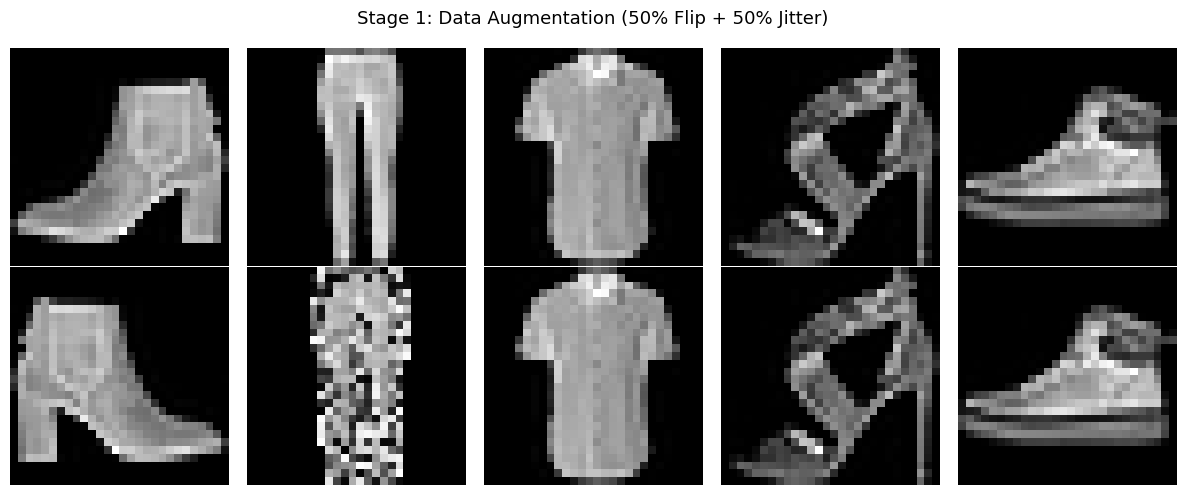

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader

loader = DataLoader()

# ---------------------------------------------------------
# 1a. Preprocessing Comparison: Z-Score vs Min-Max
# ---------------------------------------------------------
df_zscore = loader.get_z_score_df()
df_minmax = loader.get_min_max_df()
df_raw = loader.get_standard_df()

print("=" * 60)
print("PREPROCESSING COMPARISON")
print("=" * 60)

for name, df in [("Raw (0-255)", df_raw), ("Z-Score", df_zscore), ("Min-Max", df_minmax)]:
    features = df[loader.feature_cols]
    print(f"\n{name}:")
    print(f"  Mean:  {features.mean().mean():.4f}")
    print(f"  Std:   {features.std().mean():.4f}")
    print(f"  Min:   {features.min().min():.4f}")
    print(f"  Max:   {features.max().max():.4f}")

# ---------------------------------------------------------
# 1b. Data Splitting with proper pipeline (preprocess=True)
# ---------------------------------------------------------
data_dict = loader.prepare_data(
    test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=1,
    preprocess=True, normalize="z_score"
)

print(f"\n{'=' * 60}")
print(f"SEMI-SUPERVISED SPLIT (with preprocessing + augmentation)")
print(f"{'=' * 60}")
print(f"  Labeled train:   {len(data_dict['labeled_train']):,} (includes augmented)")
print(f"  Unlabeled train: {len(data_dict['unlabeled_train']):,}")
print(f"  Validation:      {len(data_dict['validation']):,}")
print(f"  Test:            {len(data_dict['test']):,}")

# ---------------------------------------------------------
# 1c. Class Distribution
# ---------------------------------------------------------
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# ---------------------------------------------------------
# 1d. Augmentation Demo (50% flip + 50% jitter)
# ---------------------------------------------------------
raw_data = loader.prepare_data(
    test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=1,
    preprocess=False  # Get raw for demo
)
sample = raw_data['labeled_train'].head(5)
augmented = loader.augment_combined(sample, flip_prob=0.5, jitter_prob=0.5)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    orig_img = sample.iloc[i][loader.feature_cols].values.reshape(28, 28)
    aug_img = augmented.iloc[i][loader.feature_cols].values.reshape(28, 28)
    axes[0][i].imshow(orig_img, cmap='gray'); axes[0][i].axis('off')
    axes[1][i].imshow(aug_img, cmap='gray'); axes[1][i].axis('off')
    if i == 0:
        axes[0][i].set_ylabel('Original')
        axes[1][i].set_ylabel('Augmented')

plt.suptitle('Stage 1: Data Augmentation (50% Flip + 50% Jitter)', fontsize=13)
plt.tight_layout()
plt.show()

# Stage 2: Supervised Neural Network Baseline

**Architecture:** 784 â†’ 1028 (ReLU) â†’ 1028 (ReLU) â†’ 10 (Softmax via CrossEntropyLoss)

**Training:** SGD with mini-batch (batch=64), learning rate=0.01, momentum=0.5

**Ablation Configurations** (each with 5 seeds for statistical rigor):

| Config | Preprocess | Init | Model |
|--------|-----------|------|-------|
| `baseline` | No (raw) | normal | VanillaModel |
| `+preprocessing` | Yes (Z-score + aug) | normal | VanillaModel |
| `+he_init` | Yes | He | VanillaModel |

**Note:** Preprocessing includes normalization (train stats only) + augmentation (50% flip + 50% jitter on train only).

## Overfitting Detection

**Criterion:** $E_V^{(t)} > \bar{E}_V + k \cdot \sigma_{E_V} \cdot \sqrt{t_0 / t}$



In [3]:
import torch
import numpy as np
from DataLoader import DataLoader
from VanillaModel import set_seed, train_loop, VanillaModel
from Results import Results

results = Results(base_dir="results")

# ---------------------------------------------------------
# Ablation configurations (simplified: preprocess = norm + aug)
# ---------------------------------------------------------
ABLATION_CONFIGS = [
    {"config": "baseline",       "preprocess": False, "init": "normal"},
    {"config": "+preprocessing", "preprocess": True,  "init": "normal"},
    {"config": "+he_init",       "preprocess": True,  "init": "he"},
]

EPOCHS = 200
LR = 0.01
MOMENTUM = 0.5
SEEDS = [1, 42, 123, 456, 12345]

def run_ablation(cfg, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=cfg["preprocess"], normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    norm_tag = "z_score" if cfg["preprocess"] else "raw"
    aug_tag = "flip+jitter" if cfg["preprocess"] else "none"

    results.begin_run(
        seed=seed, weight_init=cfg["init"], normalization=norm_tag,
        augmentations=aug_tag, config=cfg["config"], lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = VanillaModel(init_strategy=cfg["init"], lr=LR, momentum=MOMENTUM).to(device)
    return train_loop(model, loaders, device, results=results, epochs=EPOCHS)

# ---------------------------------------------------------
# Run all configs x seeds
# ---------------------------------------------------------
for cfg in ABLATION_CONFIGS:
    print(f"\n{'='*60}")
    print(f"Config: {cfg['config']}")
    print(f"{'='*60}")
    for seed in SEEDS:
        print(f"   Seed {seed}...")
        acc, ep = run_ablation(cfg, seed)
        print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep}")

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
print(f"\n{'='*60}")
print(f"STAGE 2 ABLATION SUMMARY")
print(f"{'='*60}")
results.summary()


Config: baseline
   Seed 1...
      Epoch 020 | Train Acc: 0.0975 | Val Acc: 0.0984
      Epoch 040 | Train Acc: 0.0975 | Val Acc: 0.0984
      Epoch 060 | Train Acc: 0.0975 | Val Acc: 0.0984
      Epoch 080 | Train Acc: 0.0975 | Val Acc: 0.0984
      Epoch 100 | Train Acc: 0.0975 | Val Acc: 0.0984
      Epoch 120 | Train Acc: 0.0975 | Val Acc: 0.0984
      Epoch 140 | Train Acc: 0.0975 | Val Acc: 0.0984
      >>> Overfitting at epoch 159
   -> Test Acc: 0.0991 | Epochs: 159
   Seed 42...
      Epoch 020 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 040 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 060 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 080 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 100 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 120 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 140 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 160 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 180 | Train Acc: 0.1027 | Val Acc: 0.1040
      Epoch 200 | T

We see that adding preprocessing provides a great improvement to test accuracy (from ~10% random chance to ~86%).

## Weight Initialization Comparison

We compare three initialization strategies:
1. **Random Uniform**: $w \sim U[-1/\sqrt{fan_{in}}, 1/\sqrt{fan_{in}}]$
2. **Random Normal**: $w \sim N(0, 0.01)$
3. **He Initialization**: $w \sim N(0, \sqrt{2/fan_{in}})$ - designed for ReLU activations

This isolates the effect of initialization with all other factors held constant.

In [4]:
import torch
import numpy as np
from DataLoader import DataLoader
from VanillaModel import set_seed, train_loop, VanillaModel
from Results import Results

# ---------------------------------------------------------
# Weight Initialization Comparison (with optimal LR/Momentum)
# ---------------------------------------------------------
INIT_STRATEGIES = ["uniform", "normal", "he"]
INIT_LABELS = {
    "uniform": "Random Uniform [-1/sqrt(fan_in), 1/sqrt(fan_in)]",
    "normal": "Random Normal N(0, 0.01)",
    "he": "He Initialization N(0, sqrt(2/fan_in))"
}

EPOCHS = 200
LR = 0.01 
MOMENTUM = 0.75  
SEEDS = [1, 42, 123, 456, 12345]

results = Results(base_dir="results")

def run_init_comparison(init_strategy, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    config_tag = f"init_{init_strategy}"
    results.begin_run(
        seed=seed, weight_init=init_strategy, normalization="z_score",
        augmentations="flip+jitter", config=config_tag, lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = VanillaModel(init_strategy=init_strategy, lr=LR, momentum=MOMENTUM).to(device)
    return train_loop(model, loaders, device, results=results, epochs=EPOCHS)

# ---------------------------------------------------------
# Run all init strategies x seeds
# ---------------------------------------------------------
init_results = {s: [] for s in INIT_STRATEGIES}

for init_strat in INIT_STRATEGIES:
    print(f"\n{'='*60}")
    print(f"Init Strategy: {INIT_LABELS[init_strat]}")
    print(f"{'='*60}")
    for seed in SEEDS:
        print(f"   Seed {seed}...")
        acc, ep = run_init_comparison(init_strat, seed)
        init_results[init_strat].append(acc)
        print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep}")

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
print(f"\n{'='*70}")
print(f"WEIGHT INITIALIZATION COMPARISON (LR={LR}, Momentum={MOMENTUM})")
print(f"{'='*70}")
print(f"{'Strategy':<45} | {'Test Accuracy':>18}")
print(f"{'-'*45}-+-{'-'*18}")

best_init = None
best_acc = 0

for init_strat in INIT_STRATEGIES:
    accs = np.array(init_results[init_strat])
    mean_acc = accs.mean()
    std_acc = accs.std()
    print(f"{INIT_LABELS[init_strat]:<45} | {mean_acc:.4f} +/- {std_acc:.4f}")
    if mean_acc -std_acc > best_acc:
        best_acc = mean_acc - std_acc
        best_init = init_strat

print(f"\n>>> Best initialization: {INIT_LABELS[best_init]} ({best_acc:.4f})")
print(f">>> Using He initialization for remaining experiments.")


Init Strategy: Random Uniform [-1/sqrt(fan_in), 1/sqrt(fan_in)]
   Seed 1...
      Epoch 020 | Train Acc: 0.9914 | Val Acc: 0.8510
      >>> Overfitting at epoch 35
   -> Test Acc: 0.8574 | Epochs: 35
   Seed 42...
      Epoch 020 | Train Acc: 0.9937 | Val Acc: 0.8507
      >>> Overfitting at epoch 37
   -> Test Acc: 0.8526 | Epochs: 37
   Seed 123...
      Epoch 020 | Train Acc: 0.9905 | Val Acc: 0.8563
      >>> Overfitting at epoch 29
   -> Test Acc: 0.8659 | Epochs: 29
   Seed 456...
      Epoch 020 | Train Acc: 0.9947 | Val Acc: 0.8504
      >>> Overfitting at epoch 22
   -> Test Acc: 0.8470 | Epochs: 22
   Seed 12345...
      >>> Overfitting at epoch 15
   -> Test Acc: 0.8443 | Epochs: 15

Init Strategy: Random Normal N(0, 0.01)
   Seed 1...
      Epoch 020 | Train Acc: 0.9805 | Val Acc: 0.8387 ** OVERFIT **
      >>> Overfitting at epoch 20
   -> Test Acc: 0.8416 | Epochs: 20
   Seed 42...
      Epoch 020 | Train Acc: 0.9801 | Val Acc: 0.8419
      >>> Overfitting at epoch 26
 

We will proceed with He initialization

## Normalization Strategy Comparison

Comparing **Z-score** (zero mean, unit variance) vs **Min-Max** (scale to [0, 1]) normalization on a single seed to determine which to use for the rest of the pipeline.

NORMALIZATION COMPARISON (seed=42)
      >>> Overfitting at epoch 23
  z_score    | Test Acc: 0.8496 | Converged: 23 epochs
      >>> Overfitting at epoch 27
  min_max    | Test Acc: 0.8397 | Converged: 27 epochs


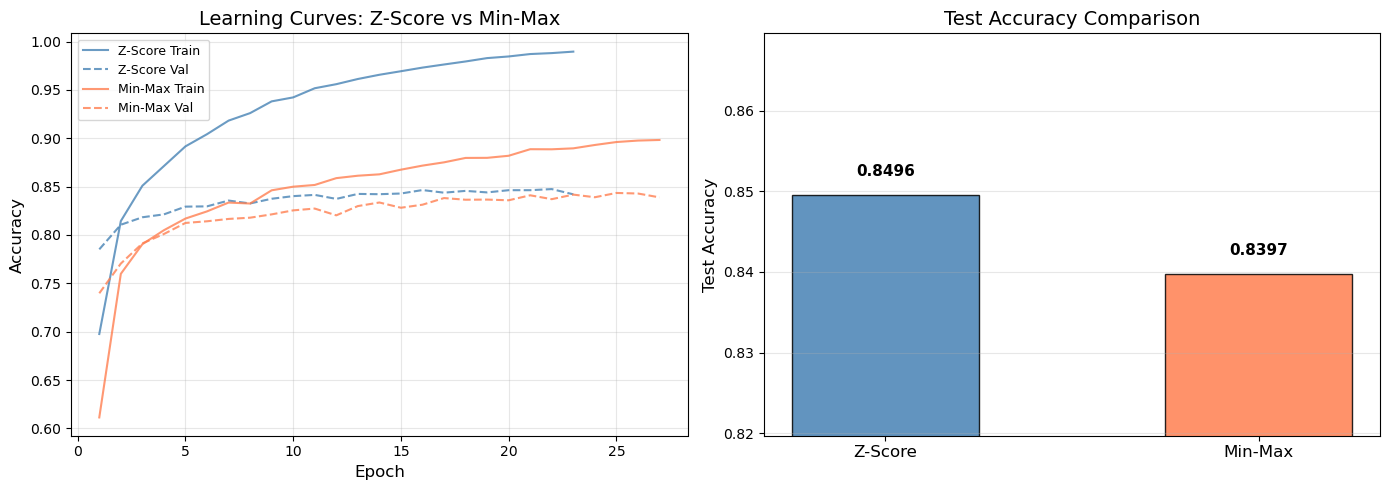


  Z-Score wins by 0.99 percentage points.
  Proceeding with Z-Score normalization for all subsequent experiments.


In [6]:
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from VanillaModel import set_seed, train_loop, VanillaModel
import torch

SEED = 42
EPOCHS = 200
LR = 0.001
MOMENTUM = 0.9

def run_with_normalization(norm_type, seed):
    """Train with specified normalization. Returns (test_acc, train_curve, val_curve, converged)."""
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize=norm_type
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    set_seed(seed)
    model = VanillaModel(input_size=784, hidden_size=1028, init_strategy="he",
                        lr=LR, momentum=MOMENTUM).to(device)

    test_acc, converged, train_accs, val_accs = train_loop(
        model, loaders, device, epochs=EPOCHS, print_every=0, collect_curves=True
    )
    return test_acc, train_accs, val_accs, converged

# ---------------------------------------------------------
# Run both
# ---------------------------------------------------------
print("=" * 70)
print(f"NORMALIZATION COMPARISON (seed={SEED})")
print("=" * 70)

norm_results = {}
for norm in ["z_score", "min_max"]:
    acc, tr, va, ep = run_with_normalization(norm, SEED)
    norm_results[norm] = {"acc": acc, "train": tr, "val": va, "epochs": ep}
    print(f"  {norm:<10} | Test Acc: {acc:.4f} | Converged: {ep} epochs")

# ---------------------------------------------------------
# Plot learning curves side by side
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = {"z_score": "steelblue", "min_max": "coral"}
labels = {"z_score": "Z-Score", "min_max": "Min-Max"}

for norm, res in norm_results.items():
    epochs = range(1, len(res["train"]) + 1)
    ax1.plot(epochs, res["train"], color=colors[norm], linestyle='-',
             label=f'{labels[norm]} Train', alpha=0.8)
    ax1.plot(epochs, res["val"], color=colors[norm], linestyle='--',
             label=f'{labels[norm]} Val', alpha=0.8)

ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Learning Curves: Z-Score vs Min-Max", fontsize=14)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Bar chart
norms = list(norm_results.keys())
accs = [norm_results[n]["acc"] for n in norms]
bar_colors = [colors[n] for n in norms]

bars = ax2.bar(range(len(norms)), accs, color=bar_colors, edgecolor='black', alpha=0.85, width=0.5)
ax2.set_xticks(range(len(norms)))
ax2.set_xticklabels([labels[n] for n in norms], fontsize=12)
ax2.set_ylabel("Test Accuracy", fontsize=12)
ax2.set_title("Test Accuracy Comparison", fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

for bar, a in zip(bars, accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{a:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

y_min = min(accs) - 0.02
y_max = max(accs) + 0.02
ax2.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
z_acc = norm_results["z_score"]["acc"]
mm_acc = norm_results["min_max"]["acc"]
diff = (z_acc - mm_acc) * 100
winner = "Z-Score" if z_acc >= mm_acc else "Min-Max"
print(f"\n  {winner} wins by {abs(diff):.2f} percentage points.")
print(f"  Proceeding with Z-Score normalization for all subsequent experiments.")


**Z-Score normalization** centers each feature to mean 0 and standard deviation 1, while **Min-Max** scales to [0, 1].

Z-Score is preferred here because:
- **Gradient stability:** With zero-centered inputs, neuron activations are balanced around zero, preventing systematic bias in early layers. Min-Max maps everything to [0, 1], meaning all inputs are positive, which can cause all-positive or all-negative gradients and slow convergence.
- **Outlier handling:** Z-Score preserves relative distances between samples even when a few pixels have extreme values. Min-Max compresses the majority of values into a narrow range if outliers exist.
- **Compatibility with He initialization:** He init assumes zero-mean inputs to calibrate weight variance. Z-Score satisfies this assumption directly.

We proceed with Z-Score normalization for all subsequent experiments.

## Hyperparameter Tuning

 We will run empirical analysis on this model to determine an optimal learning rate and momentum for this training set.

**Pessimistic Metric (worst-case):** $\text{score} = \mu_{\text{acc}} - \sigma_{\text{acc}}$

This metric penalizes high-variance configurations, favoring stable hyperparameters that perform well consistently across seeds.

**Search Strategy:**
1. **Phase 1 (Coarse):** Grid search over LR Ã— Momentum with 2 seeds each
2. **Phase 2 (Refine):** Take top 5 configurations by pessimistic metric, run with 5 seeds
3. **Selection:** Choose configuration with highest pessimistic score from Phase 2

PHASE 1: Coarse Grid Search (LR x Momentum, 2 seeds each)
  [ 1/20] LR=0.0010, M=0.00 | Acc: 0.8059 +/- 0.0053 | Pessimistic: 0.8006
      >>> Overfitting at epoch 98
      >>> Overfitting at epoch 89
  [ 2/20] LR=0.0010, M=0.50 | Acc: 0.8396 +/- 0.0051 | Pessimistic: 0.8346
      >>> Overfitting at epoch 37
      >>> Overfitting at epoch 36
  [ 3/20] LR=0.0010, M=0.90 | Acc: 0.8531 +/- 0.0006 | Pessimistic: 0.8526
      >>> Overfitting at epoch 21
      >>> Overfitting at epoch 20
  [ 4/20] LR=0.0010, M=0.95 | Acc: 0.8474 +/- 0.0001 | Pessimistic: 0.8473
      >>> Overfitting at epoch 44
      >>> Overfitting at epoch 55
  [ 5/20] LR=0.0050, M=0.00 | Acc: 0.8470 +/- 0.0024 | Pessimistic: 0.8446
      >>> Overfitting at epoch 32
      >>> Overfitting at epoch 31
  [ 6/20] LR=0.0050, M=0.50 | Acc: 0.8519 +/- 0.0004 | Pessimistic: 0.8516
      >>> Overfitting at epoch 22
      >>> Overfitting at epoch 36
  [ 7/20] LR=0.0050, M=0.90 | Acc: 0.8501 +/- 0.0022 | Pessimistic: 0.8479
      >>>

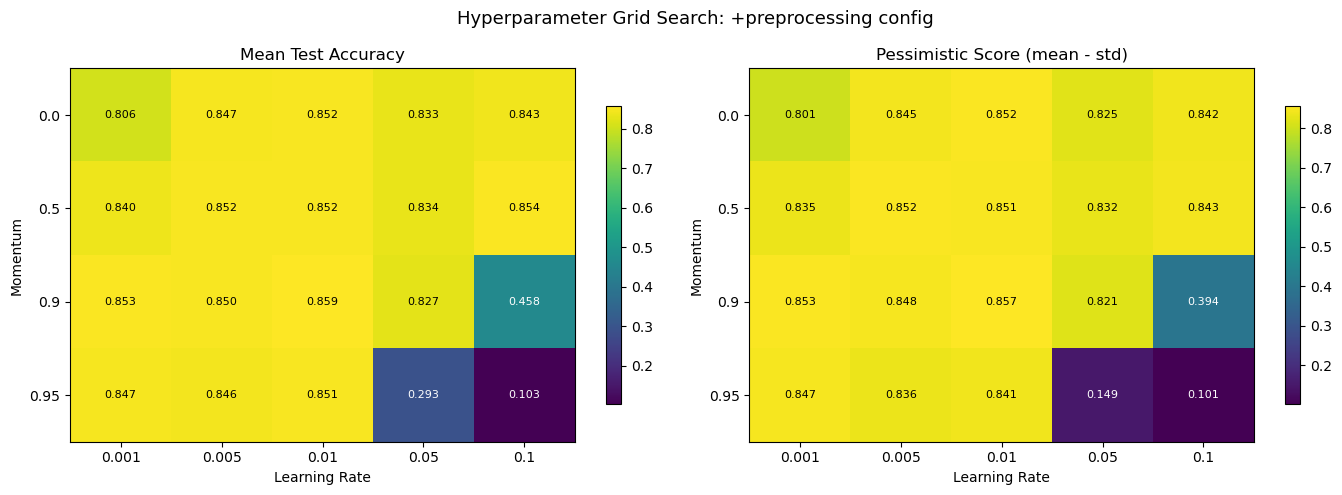


Best hyperparameters saved: LR=0.01, Momentum=0.9


In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from VanillaModel import set_seed, train_loop, VanillaModel

# ---------------------------------------------------------
# Hyperparameter Grid
# ---------------------------------------------------------
LR_VALUES = [0.001, 0.005, 0.01, 0.05, 0.1]
MOMENTUM_VALUES = [0.0, 0.5, 0.9, 0.95]
EPOCHS = 100

# Phase 1: 2 seeds for coarse search
PHASE1_SEEDS = [1, 42]
# Phase 2: 5 seeds for top candidates
PHASE2_SEEDS = [1, 42, 123, 456, 12345]

def train_config(lr, momentum, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize="z_score"
    )
    
    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)
    
    set_seed(seed)
    model = VanillaModel(init_strategy="normal", lr=lr, momentum=momentum).to(device)
    test_acc, _ = train_loop(model, loaders, device, epochs=EPOCHS, print_every=0)
    return test_acc

# ---------------------------------------------------------
# Phase 1: Coarse grid search (2 seeds)
# ---------------------------------------------------------
print("=" * 70)
print("PHASE 1: Coarse Grid Search (LR x Momentum, 2 seeds each)")
print("=" * 70)

phase1_results = []
total_configs = len(LR_VALUES) * len(MOMENTUM_VALUES)
config_idx = 0

for lr in LR_VALUES:
    for momentum in MOMENTUM_VALUES:
        config_idx += 1
        accs = []
        for seed in PHASE1_SEEDS:
            acc = train_config(lr, momentum, seed)
            accs.append(acc)
        
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        pessimistic = mean_acc - std_acc
        
        phase1_results.append({
            "lr": lr, "momentum": momentum,
            "mean_acc": mean_acc, "std_acc": std_acc,
            "pessimistic": pessimistic
        })
        
        print(f"  [{config_idx:2d}/{total_configs}] LR={lr:.4f}, M={momentum:.2f} | "
              f"Acc: {mean_acc:.4f} +/- {std_acc:.4f} | Pessimistic: {pessimistic:.4f}")

# Sort by pessimistic metric and take top 5
phase1_df = pd.DataFrame(phase1_results)
phase1_df = phase1_df.sort_values("pessimistic", ascending=False)
top5 = phase1_df.head(5)

print(f"\n{'='*70}")
print("TOP 5 CONFIGURATIONS (by pessimistic metric)")
print("=" * 70)
for i, row in top5.iterrows():
    print(f"  LR={row['lr']:.4f}, M={row['momentum']:.2f} | "
          f"Pessimistic: {row['pessimistic']:.4f}")

# ---------------------------------------------------------
# Phase 2: Refined search on top 5 (5 seeds)
# ---------------------------------------------------------
print(f"\n{'='*70}")
print("PHASE 2: Refined Search on Top 5 (5 seeds each)")
print("=" * 70)

phase2_results = []

for _, row in top5.iterrows():
    lr, momentum = row["lr"], row["momentum"]
    accs = []
    for seed in PHASE2_SEEDS:
        acc = train_config(lr, momentum, seed)
        accs.append(acc)
    
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    pessimistic = mean_acc - std_acc
    
    phase2_results.append({
        "lr": lr, "momentum": momentum,
        "mean_acc": mean_acc, "std_acc": std_acc,
        "pessimistic": pessimistic,
        "accs": accs
    })
    
    print(f"  LR={lr:.4f}, M={momentum:.2f} | "
          f"Acc: {mean_acc:.4f} +/- {std_acc:.4f} | Pessimistic: {pessimistic:.4f}")

# Select best
phase2_df = pd.DataFrame(phase2_results)
best_idx = phase2_df["pessimistic"].idxmax()
best = phase2_df.loc[best_idx]

print(f"\n{'='*70}")
print("BEST HYPERPARAMETERS (by pessimistic metric)")
print("=" * 70)
print(f"  Learning Rate: {best['lr']}")
print(f"  Momentum:      {best['momentum']}")
print(f"  Test Accuracy: {best['mean_acc']:.4f} +/- {best['std_acc']:.4f}")
print(f"  Pessimistic:   {best['pessimistic']:.4f}")

# ---------------------------------------------------------
# Visualization: Heatmap of Phase 1 results
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pivot_mean = phase1_df.pivot(index="momentum", columns="lr", values="mean_acc")
pivot_pess = phase1_df.pivot(index="momentum", columns="lr", values="pessimistic")

for ax, data, title in [
    (axes[0], pivot_mean, "Mean Test Accuracy"),
    (axes[1], pivot_pess, "Pessimistic Score (mean - std)")
]:
    im = ax.imshow(data.values, cmap="viridis", aspect="auto")
    ax.set_xticks(range(len(LR_VALUES)))
    ax.set_xticklabels([f"{lr}" for lr in LR_VALUES])
    ax.set_yticks(range(len(MOMENTUM_VALUES)))
    ax.set_yticklabels([f"{m}" for m in MOMENTUM_VALUES])
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Momentum")
    ax.set_title(title)
    
    for i in range(len(MOMENTUM_VALUES)):
        for j in range(len(LR_VALUES)):
            val = data.values[i, j]
            ax.text(j, i, f"{val:.3f}", ha="center", va="center", 
                   color="white" if val < data.values.mean() else "black", fontsize=8)
    
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle("Hyperparameter Grid Search: +preprocessing config", fontsize=13)
plt.tight_layout()
plt.show()

BEST_LR = best['lr']
BEST_MOMENTUM = best['momentum']
print(f"\nBest hyperparameters saved: LR={BEST_LR}, Momentum={BEST_MOMENTUM}")

From the phase 1 test, we see (LR,MOMENTUM) = {(0.1,0.5),(0.005,0.00),(0.001,0.9),(0.005,0.5),(0.01,0.5)} provided the best pessimist metric. After running phase 2 on these 5 pairs, in deeper stress (more seeds), we conclude that lr=.001, momentum = .9 is the best for this training set. For the rest of the experimentation, we will use these hyperparameters. We operate under the hypothesis that changing model architecture, while maintaining size, and dataset, will not alter the optimal learning rate and momentum

# Stage 3: Architecture Selection and Regularization

Two techniques implemented:
1. **L1 Regularization** - encourages sparsity in weights
2. **Magnitude-Based Pruning** - train oversized network, prune smallest weights, fine-tune

Both use Stage2Model with the loss function:
$$\mathcal{L}(w) = \mathcal{L}_{CE} + \lambda_1 |w|$$

## L1 Lambda Tuning

Testing L1 regularization strength across the range specified in the assignment: $\lambda \in \{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}\}$. Single seed run to find the best lambda before committing to 5-seed experiments.

L1 LAMBDA TUNING (seed=42)
      >>> Overfitting at epoch 23
  lambda=1e-05 | Test Acc: 0.8503 | Epochs: 23 | Near-zero weights: 0.4%
      >>> Overfitting at epoch 35
  lambda=1e-04 | Test Acc: 0.8506 | Epochs: 35 | Near-zero weights: 10.2%
      >>> Overfitting at epoch 21
  lambda=1e-03 | Test Acc: 0.8389 | Epochs: 21 | Near-zero weights: 56.1%
      >>> Overfitting at epoch 36
  lambda=1e-02 | Test Acc: 0.2443 | Epochs: 36 | Near-zero weights: 99.9%


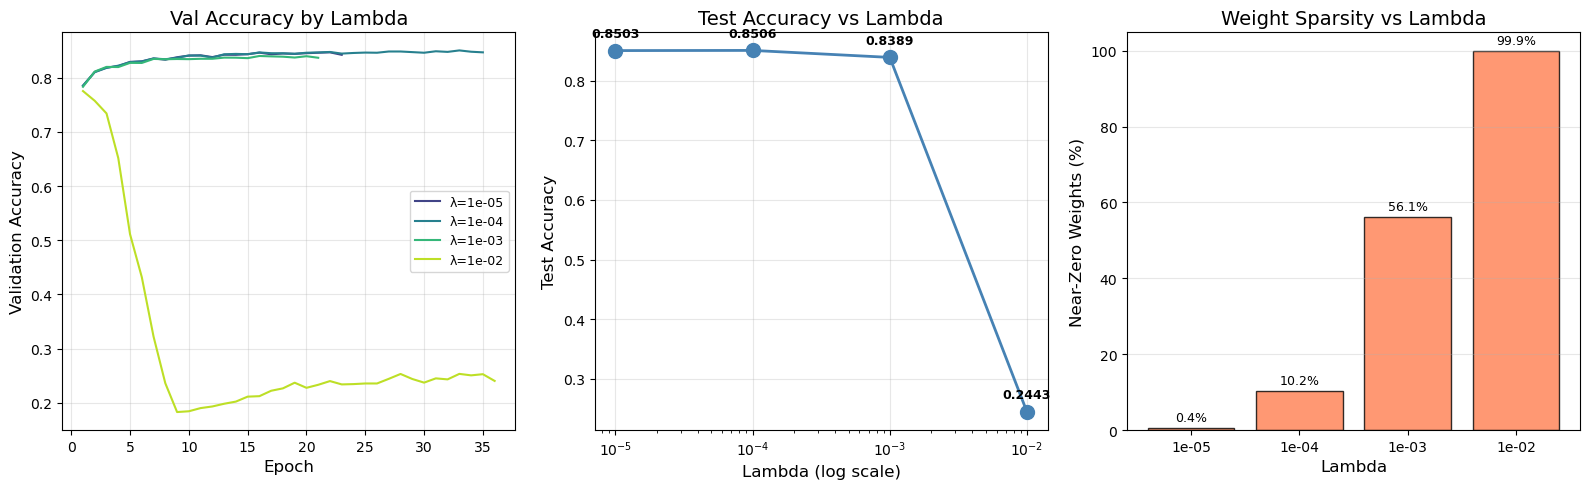


BEST lambda = 1e-04  ->  Test Acc: 0.8506  (epochs: 35, sparsity: 10.2%)

Use lambda=1e-04 for subsequent L1 regularization experiments.


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop

SEED = 42
EPOCHS = 200
LR = 0.001
MOMENTUM = 0.9
LAMBDAS = [1e-5, 1e-4, 1e-3, 1e-2]

def run_lambda_experiment(lam, seed):
    """Train Stage2Model with given L1 lambda. Returns (test_acc, train_accs, val_accs, converged, sparsity)."""
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    set_seed(seed)
    model = Stage2Model(input_size=784, hidden_size=1028, init_strategy="he",
                        lr=LR, momentum=MOMENTUM, lambda1=lam).to(device)

    test_acc, converged, train_accs, val_accs = train_loop(
        model, loaders, device, epochs=EPOCHS, print_every=0, collect_curves=True
    )

    total_params = 0
    near_zero = 0
    with torch.no_grad():
        for p in model.parameters():
            total_params += p.numel()
            near_zero += (p.abs() < 1e-4).sum().item()
    sparsity = near_zero / total_params

    return test_acc, train_accs, val_accs, converged, sparsity

# ---------------------------------------------------------
# Run
# ---------------------------------------------------------
print("=" * 70)
print(f"L1 LAMBDA TUNING (seed={SEED})")
print("=" * 70)

lambda_results = []
for lam in LAMBDAS:
    acc, tr, va, ep, sp = run_lambda_experiment(lam, SEED)
    lambda_results.append({
        "lambda": lam, "test_acc": acc, "train_accs": tr, "val_accs": va,
        "epochs": ep, "sparsity": sp
    })
    print(f"  lambda={lam:.0e} | Test Acc: {acc:.4f} | Epochs: {ep} | Near-zero weights: {sp:.1%}")

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(LAMBDAS)))
for res, c in zip(lambda_results, colors):
    epochs = range(1, len(res["val_accs"]) + 1)
    ax1.plot(epochs, res["val_accs"], color=c, linewidth=1.5,
             label=f'\u03bb={res["lambda"]:.0e}')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Validation Accuracy", fontsize=12)
ax1.set_title("Val Accuracy by Lambda", fontsize=14)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
lams = [r["lambda"] for r in lambda_results]
accs = [r["test_acc"] for r in lambda_results]
ax2.semilogx(lams, accs, 'o-', color='steelblue', linewidth=2, markersize=10)
ax2.set_xlabel("Lambda (log scale)", fontsize=12)
ax2.set_ylabel("Test Accuracy", fontsize=12)
ax2.set_title("Test Accuracy vs Lambda", fontsize=14)
ax2.grid(True, alpha=0.3)
for l, a in zip(lams, accs):
    ax2.annotate(f"{a:.4f}", (l, a), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')

ax3 = axes[2]
sparsities = [r["sparsity"] * 100 for r in lambda_results]
bars = ax3.bar(range(len(lams)), sparsities, color='coral', edgecolor='black', alpha=0.8)
ax3.set_xlabel("Lambda", fontsize=12)
ax3.set_ylabel("Near-Zero Weights (%)", fontsize=12)
ax3.set_title("Weight Sparsity vs Lambda", fontsize=14)
ax3.set_xticks(range(len(lams)))
ax3.set_xticklabels([f'{l:.0e}' for l in lams])
ax3.grid(True, alpha=0.3, axis='y')
for i, s in enumerate(sparsities):
    ax3.text(i, s + max(sparsities)*0.02, f'{s:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

best = max(lambda_results, key=lambda r: r["test_acc"])
print(f"\n{'='*70}")
print(f"BEST lambda = {best['lambda']:.0e}  ->  Test Acc: {best['test_acc']:.4f}  "
      f"(epochs: {best['epochs']}, sparsity: {best['sparsity']:.1%})")
print(f"{'='*70}")
print(f"\nUse lambda={best['lambda']:.0e} for subsequent L1 regularization experiments.")

## Stage 3a: L1 Regularization

Adds L1 regularization to the baseline pipeline. Uses Stage2Model with hidden_size=1028 (same as baseline) and no pruning - isolating the effect of regularization.

In [9]:
import torch
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop
from Results import Results

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

results = Results(base_dir="results")

EPOCHS = 200
LR = 0.001
MOMENTUM = 0.9
SEEDS = [1, 42, 123, 456, 12345]
CONFIG_TAG = "+l1_reg"

def run_l1_reg(seed):
    set_seed(seed)
    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=CONFIG_TAG, lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(
        hidden_size=1028, init_strategy="he", lr=LR, momentum=MOMENTUM,
        lambda1=1e-4
    ).to(device)

    return train_loop(model, loaders, device, results=results, epochs=EPOCHS)

# ---------------------------------------------------------
# Run 5 seeds
# ---------------------------------------------------------
print(f"{'='*60}")
print(f"Config: {CONFIG_TAG} (Stage2Model hidden=1028, L1 reg)")
print(f"{'='*60}")
for seed in SEEDS:
    print(f"   Seed {seed}...")
    acc, ep = run_l1_reg(seed)
    print(f"   -> Test Acc: {acc:.4f} | Epochs: {ep}")

results.summary()

cuda
Config: +l1_reg (Stage2Model hidden=1028, L1 reg)
   Seed 1...
      >>> Overfitting at epoch 19
   -> Test Acc: 0.8489 | Epochs: 19
   Seed 42...
      Epoch 020 | Train Acc: 0.9790 | Val Acc: 0.8460
      >>> Overfitting at epoch 35
   -> Test Acc: 0.8506 | Epochs: 35
   Seed 123...
      >>> Overfitting at epoch 16
   -> Test Acc: 0.8587 | Epochs: 16
   Seed 456...
      Epoch 020 | Train Acc: 0.9792 | Val Acc: 0.8436
      >>> Overfitting at epoch 24
   -> Test Acc: 0.8466 | Epochs: 24
   Seed 12345...
      Epoch 020 | Train Acc: 0.9773 | Val Acc: 0.8406
      >>> Overfitting at epoch 25
   -> Test Acc: 0.8467 | Epochs: 25
               +l1_reg | Test Acc: 0.8503 +/- 0.0045 | Epochs: 23.8 +/- 6.5 | n=5


## Stage 3a continued: Magnitude-Based Pruning

Adds pruning on top of L1 regularization. Uses Stage2Model with:
- **2x wider** network (hidden_size=2056)
- L1 regularization during pre-training
- Global magnitude pruning at **{10%, 25%, 50%}** rates
- Fine-tuning after pruning



Pruning 10%
   Seed 1...
      Epoch 020 | Train Acc: 0.9891 | Val Acc: 0.8513
      >>> Overfitting at epoch 33
   Pruned 585960/5859600 weights (10.0%) at threshold=0.000008
      Post-prune (10%): 0.8560 | Sparsity: 10.0%
      >>> Overfitting at epoch 17
   -> Pre: 0.8560 | Post: 0.8560 | Fine-tuned: 0.8560
   Seed 42...
      Epoch 020 | Train Acc: 0.9915 | Val Acc: 0.8477
      >>> Overfitting at epoch 24
   Pruned 585960/5859600 weights (10.0%) at threshold=0.000222
      Post-prune (10%): 0.8557 | Sparsity: 10.0%
      >>> Overfitting at epoch 31
   -> Pre: 0.8556 | Post: 0.8557 | Fine-tuned: 0.8554
   Seed 123...
      Epoch 020 | Train Acc: 0.9898 | Val Acc: 0.8566
      >>> Overfitting at epoch 26
   Pruned 585960/5859600 weights (10.0%) at threshold=0.000030
      Post-prune (10%): 0.8647 | Sparsity: 10.0%
      >>> Overfitting at epoch 16
   -> Pre: 0.8646 | Post: 0.8647 | Fine-tuned: 0.8636
   Seed 456...
      Epoch 020 | Train Acc: 0.9909 | Val Acc: 0.8481
      >>> Ov

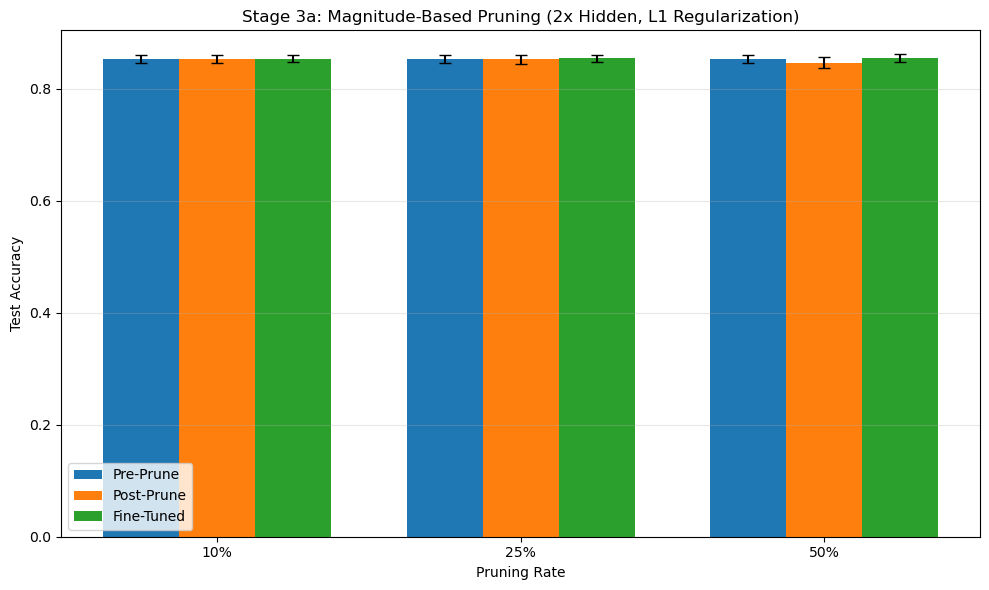

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop
from Results import Results

results = Results(base_dir="results")

PRETRAIN_EPOCHS = 200
FINETUNE_EPOCHS = 50
LR = 0.001
MOMENTUM = 0.9
PRUNE_RATES = [0.10, 0.25, 0.50]
SEEDS = [1, 42, 123, 456, 12345]

def run_pruning(seed, prune_rate):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.1, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    config_tag = f"+pruning_{int(prune_rate*100)}pct"

    # --- Phase 1: Pre-train ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=f"{config_tag}_pretrain",
        lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(hidden_size=2056, init_strategy="he",
                        lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    pre_prune_test, pretrain_converged = train_loop(
        model, loaders, device, results=results, epochs=PRETRAIN_EPOCHS
    )

    # --- Phase 2: Prune ---
    model.prune(prune_rate)
    _, post_prune_test = model.evaluate(loaders["test"], device)
    print(f"      Post-prune ({prune_rate:.0%}): {post_prune_test:.4f} | Sparsity: {model.sparsity():.1%}")

    # --- Phase 3: Fine-tune ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=config_tag, lr=LR, momentum=MOMENTUM
    )

    final_test, finetune_converged = train_loop(
        model, loaders, device, results=results, epochs=FINETUNE_EPOCHS, print_every=0
    )

    return {
        "seed": seed, "prune_rate": prune_rate,
        "pre_prune_acc": pre_prune_test,
        "post_prune_acc": post_prune_test,
        "final_acc": final_test,
    }

# ---------------------------------------------------------
# Run all combinations
# ---------------------------------------------------------
all_pruning_results = []

for prune_rate in PRUNE_RATES:
    print(f"\n{'='*60}")
    print(f"Pruning {prune_rate:.0%}")
    print(f"{'='*60}")
    for seed in SEEDS:
        print(f"   Seed {seed}...")
        r = run_pruning(seed, prune_rate)
        all_pruning_results.append(r)
        print(f"   -> Pre: {r['pre_prune_acc']:.4f} | Post: {r['post_prune_acc']:.4f} | Fine-tuned: {r['final_acc']:.4f}")

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
print(f"\n{'='*70}")
print(f"PRUNING RESULTS SUMMARY")
print(f"{'='*70}")
for rate in PRUNE_RATES:
    group = [r for r in all_pruning_results if r["prune_rate"] == rate]
    fine = np.array([r["final_acc"] for r in group])
    print(f"  {rate:>5.0%} | Fine-tuned: {fine.mean():.4f} +/- {fine.std():.4f}")

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(PRUNE_RATES))
width = 0.25

for i, (label, key) in enumerate([
    ("Pre-Prune", "pre_prune_acc"),
    ("Post-Prune", "post_prune_acc"),
    ("Fine-Tuned", "final_acc")
]):
    means = [np.mean([r[key] for r in all_pruning_results if r["prune_rate"] == rate]) for rate in PRUNE_RATES]
    stds = [np.std([r[key] for r in all_pruning_results if r["prune_rate"] == rate]) for rate in PRUNE_RATES]
    ax.bar(x + i * width, means, width, yerr=stds, label=label, capsize=4)

ax.set_xlabel("Pruning Rate")
ax.set_ylabel("Test Accuracy")
ax.set_title("Stage 3a: Magnitude-Based Pruning (2x Hidden, L1 Regularization)")
ax.set_xticks(x + width)
ax.set_xticklabels([f"{int(r*100)}%" for r in PRUNE_RATES])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Upper Bound: Fully Supervised (100% Labels)

To establish the performance ceiling, we train our best model (50% pruned with fine-tuning) using **all available labels** from the training pool. This provides the upper bound that our semi-supervised approach aims to match.

**Comparison:**
- Semi-supervised (20% labeled): Uses only 20% of training labels + pseudo-labels from unlabeled data
- Fully supervised (100% labeled): Uses all training labels

The gap between these shows the potential benefit of semi-supervised learning when labels are scarce.

In [11]:
import torch
import numpy as np
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop
from Results import Results

results = Results(base_dir="results")

# ---------------------------------------------------------
# Fully Supervised: 50% pruned model with 100% labels
# ---------------------------------------------------------
PRETRAIN_EPOCHS = 200
FINETUNE_EPOCHS = 100
LR = 0.001
MOMENTUM = 0.9
PRUNE_RATE = 0.50
SEEDS = [1, 42, 123, 456, 12345]
CONFIG_TAG = "fully_supervised_100pct"

def run_fully_supervised(seed):
    """Train 50% pruned model with 100% of labels."""
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=1.0, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    print(f"   Training samples: {len(data_dict['labeled_train'])}")

    # --- Phase 1: Pre-train 2x wide network ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=f"{CONFIG_TAG}_pretrain",
        lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(hidden_size=2056, init_strategy="he",
                        lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    pre_prune_test, pretrain_converged = train_loop(
        model, loaders, device, results=results, epochs=PRETRAIN_EPOCHS
    )

    # --- Phase 2: Prune 50% ---
    model.prune(PRUNE_RATE)
    _, post_prune_test = model.evaluate(loaders["test"], device)
    print(f"      Post-prune ({PRUNE_RATE:.0%}): {post_prune_test:.4f} | Sparsity: {model.sparsity():.1%}")

    # --- Phase 3: Fine-tune ---
    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=CONFIG_TAG, lr=LR, momentum=MOMENTUM
    )

    final_test, finetune_converged = train_loop(
        model, loaders, device, results=results, epochs=FINETUNE_EPOCHS, print_every=0
    )

    print(f"   -> Pre: {pre_prune_test:.4f} | Post: {post_prune_test:.4f} | Final: {final_test:.4f}")
    return final_test

# ---------------------------------------------------------
# Run
# ---------------------------------------------------------
print("=" * 70)
print("FULLY SUPERVISED BASELINE (100% Labels, 50% Pruned)")
print("=" * 70)

fully_supervised_results = []
for seed in SEEDS:
    print(f"\n   Seed {seed}...")
    acc = run_fully_supervised(seed)
    fully_supervised_results.append(acc)

fs_accs = np.array(fully_supervised_results)

FULLY_SUPERVISED_ACC = fs_accs.mean()
FULLY_SUPERVISED_STD = fs_accs.std()
print(f"\n>>> Upper bound: {FULLY_SUPERVISED_ACC:.4f} +/- {FULLY_SUPERVISED_STD:.4f}")

FULLY SUPERVISED BASELINE (100% Labels, 50% Pruned)

   Seed 1...
   Training samples: 112000
      Epoch 020 | Train Acc: 0.9313 | Val Acc: 0.8936
      >>> Overfitting at epoch 24
   Pruned 2929800/5859600 weights (50.0%) at threshold=0.000031
      Post-prune (50%): 0.8913 | Sparsity: 50.0%
      >>> Overfitting at epoch 24
   -> Pre: 0.8916 | Post: 0.8913 | Final: 0.8951

   Seed 42...
   Training samples: 112000
      Epoch 020 | Train Acc: 0.9313 | Val Acc: 0.8907
      >>> Overfitting at epoch 22
   Pruned 2929800/5859600 weights (50.0%) at threshold=0.000035
      Post-prune (50%): 0.8917 | Sparsity: 50.0%
      >>> Overfitting at epoch 17
   -> Pre: 0.8910 | Post: 0.8917 | Final: 0.8921

   Seed 123...
   Training samples: 112000
      Epoch 020 | Train Acc: 0.9309 | Val Acc: 0.8967
      >>> Overfitting at epoch 21
   Pruned 2929800/5859600 weights (50.0%) at threshold=0.000036
      Post-prune (50%): 0.9026 | Sparsity: 50.0%
      >>> Overfitting at epoch 32
   -> Pre: 0.901

# Stage 4: Semi-Supervised Learning (Label Propagation)

**Method:** Zhu & Ghahramani (2002) Label Propagation + Neural Network

**Approach:**
1. Run label propagation on labeled + unlabeled data (kNN affinity graph with RBF kernel)
2. Filter pseudo-labels by confidence threshold (keep high-confidence predictions)
3. Train Stage2Model (L1 regularization) on labeled + pseudo-labeled data
4. Compare against Stage 2 baseline to measure benefit of pseudo-labels

## Bonus: Co-Training Semi-Supervised Learning

**Method:** Blum & Mitchell (1998) Co-Training with Multi-View Learning

**Approach:**
1. **Split features into two views**: Left half (columns 0-13) and right half (columns 14-27) of each 28x28 image
2. **Train two separate classifiers**: One per view, each with architecture 392 â†’ 512 â†’ 512 â†’ 10
3. **Iterative pseudo-labeling**: Each classifier labels unlabeled data; high-confidence predictions are added to the *other* classifier's training set
4. **Prediction fusion**: Final predictions combine both views (average probabilities)

**Key Difference from Label Propagation:**
- Label propagation uses graph-based diffusion on the full feature space
- Co-training exploits feature redundancy by treating views as conditionally independent

## Label Propagation: kNN Neighbor Tuning

Finding the optimal number of neighbors (k) for the kNN affinity graph in label propagation. A larger k connects more distant points (smoother propagation but slower and may blur class boundaries). A smaller k preserves local structure but may fragment the graph.

**Setup:** Single seed, 80% confidence threshold, varying k in {5, 10, 15, 20, 30}.

kNN NEIGHBOR TUNING (seed=42, confidence=0.9)
  Labeled: 5600 | Unlabeled: 50400

--- k=5 ---
   Label propagation: building kNN graph (n=56000, k=5)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=1.41e-01
      Iteration 20/50: delta=4.99e-02
      Iteration 30/50: delta=3.67e-02
      Iteration 40/50: delta=2.32e-02
      Iteration 50/50: delta=1.75e-02
  Pseudo-labels above 0.9: 6464/50400 (12.8%)
      >>> Overfitting at epoch 19
  Test Acc: 0.8423 | Epochs: 19 | Pseudo used: 6464

--- k=10 ---
   Label propagation: building kNN graph (n=56000, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=1.50e-01
      Iteration 20/50: delta=5.01e-02
      Iteration 30/50: delta=3.67e-02
      Iteration 40/50: delta=2.31e-02
      Iteration 50/50: delta=1.75e-02
  Pseudo-labels above 0.9: 6471/50400 (12.8%)
      >>> Overfitting at epoch 28
  Test 

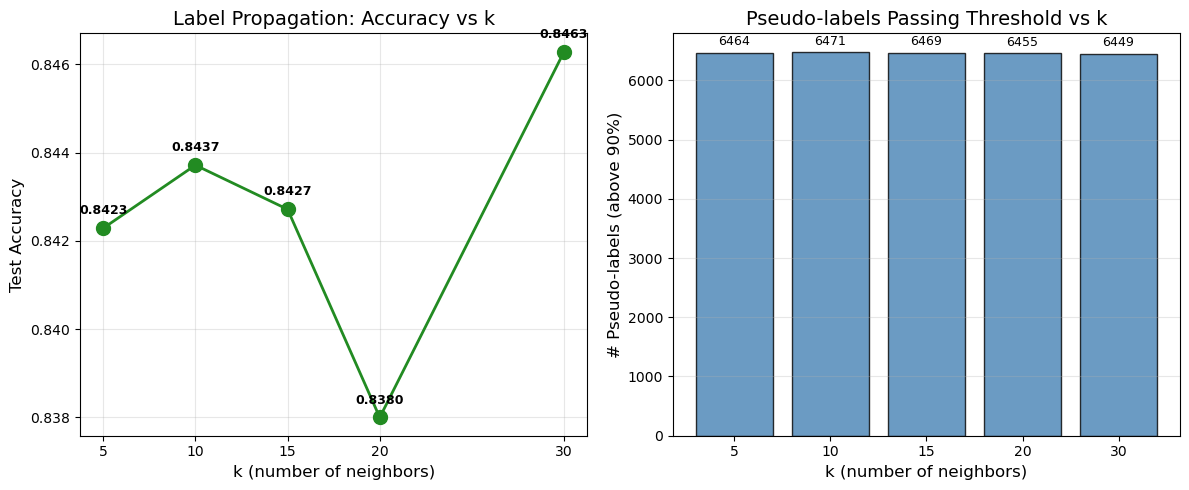


BEST k = 30  ->  Test Acc: 0.8463  (pseudo: 6449, epochs: 25)


In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from SemiSupervisedModel import LabelPropagation
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop

# ---------------------------------------------------------
# kNN Neighbor Tuning for Label Propagation
# ---------------------------------------------------------
K_VALUES = [5, 10, 15, 20, 30]
SEED = 42
CONFIDENCE = 0.9
EPOCHS = 200
LR = 0.001
MOMENTUM = 0.9

# Prepare data once
loader = DataLoader()
data_dict = loader.normalize_splits(loader.get_semi_supervised_split(
    loader.df, test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=SEED
), normalize="z_score")

X_labeled, y_labeled = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)

loaders = loader.to_torch_loaders({
    "validation": data_dict["validation"],
    "test": data_dict["test"]
}, batch_size=64)

print("=" * 70)
print(f"kNN NEIGHBOR TUNING (seed={SEED}, confidence={CONFIDENCE})")
print("=" * 70)
print(f"  Labeled: {len(y_labeled)} | Unlabeled: {len(X_unlabeled)}")

knn_results = []

for k in K_VALUES:
    print(f"\n--- k={k} ---")

    set_seed(SEED)
    lp = LabelPropagation(sigma=1.0, max_iter=50, k_neighbors=k, num_classes=10)
    X_pseudo, y_pseudo, n_pseudo = lp.generate_pseudo_labels(
        X_labeled, y_labeled, X_unlabeled, threshold=CONFIDENCE
    )

    pseudo_df = pd.DataFrame(X_pseudo, columns=loader.feature_cols)
    pseudo_df["label"] = y_pseudo
    combined = pd.concat([data_dict["labeled_train"], pseudo_df], axis=0).reset_index(drop=True)

    train_loader = loader.to_torch_loaders({"train": combined}, batch_size=64)["train"]
    all_loaders = {"train": train_loader, "validation": loaders["validation"], "test": loaders["test"]}

    set_seed(SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Stage2Model(input_size=784, hidden_size=1028,
                        init_strategy="he", lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    test_acc, converged = train_loop(model, all_loaders, device, epochs=EPOCHS, print_every=0)
    print(f"  Test Acc: {test_acc:.4f} | Epochs: {converged} | Pseudo used: {n_pseudo}")

    knn_results.append({
        "k": k, "test_acc": test_acc, "n_pseudo": n_pseudo, "epochs": converged
    })

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ks = [r["k"] for r in knn_results]
accs = [r["test_acc"] for r in knn_results]
pseudos = [r["n_pseudo"] for r in knn_results]

ax1.plot(ks, accs, 'o-', color='forestgreen', linewidth=2, markersize=10)
ax1.set_xlabel("k (number of neighbors)", fontsize=12)
ax1.set_ylabel("Test Accuracy", fontsize=12)
ax1.set_title("Label Propagation: Accuracy vs k", fontsize=14)
ax1.set_xticks(ks)
ax1.grid(True, alpha=0.3)
for k_val, acc in zip(ks, accs):
    ax1.annotate(f"{acc:.4f}", (k_val, acc), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')

ax2.bar(range(len(ks)), pseudos, color='steelblue', alpha=0.8, edgecolor='black')
ax2.set_xlabel("k (number of neighbors)", fontsize=12)
ax2.set_ylabel("# Pseudo-labels (above 90%)", fontsize=12)
ax2.set_title("Pseudo-labels Passing Threshold vs k", fontsize=14)
ax2.set_xticks(range(len(ks)))
ax2.set_xticklabels([str(k_val) for k_val in ks])
ax2.grid(True, alpha=0.3, axis='y')
for i, n in enumerate(pseudos):
    ax2.text(i, n + max(pseudos)*0.02, str(n), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

best = max(knn_results, key=lambda r: r["test_acc"])
print(f"\n{'='*70}")
print(f"BEST k = {best['k']}  ->  Test Acc: {best['test_acc']:.4f}  "
      f"(pseudo: {best['n_pseudo']}, epochs: {best['epochs']})")
print(f"{'='*70}")

k = 30 provides the highest overall accuracy, but the improvement is quite neglegible to k=10, so in the interest of efficiency, we will use k = 10 for further experimentation.

## SSL Confidence Threshold Experiment

Testing different confidence thresholds for pseudo-label filtering in both SSL methods:
- **Label Propagation**: Threshold for accepting propagated labels
- **Co-Training**: Threshold for cross-teaching between views

Lower threshold = more pseudo-labels (risk of noise), Higher threshold = fewer but cleaner labels.

CONFIDENCE THRESHOLD EXPERIMENT

--- Threshold 70% ---
  GSSL seed 1...    Label propagation: building kNN graph (n=61600, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=2.71e-01
      Iteration 20/50: delta=4.88e-02
      Iteration 30/50: delta=3.07e-02
      Iteration 40/50: delta=2.20e-02
      Iteration 50/50: delta=1.70e-02
  Pseudo-labels above 0.7: 9211/50400 (18.3%)
      >>> Overfitting at epoch 22
acc=0.8466 (pseudo=9211)
  GSSL seed 42...    Label propagation: building kNN graph (n=61600, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=1.51e-01
      Iteration 20/50: delta=5.01e-02
      Iteration 30/50: delta=3.67e-02
      Iteration 40/50: delta=2.31e-02
      Iteration 50/50: delta=1.75e-02
  Pseudo-labels above 0.7: 9057/50400 (18.0%)
      >>> Overfitting at epoch 34
acc=0.8440 (pseudo=9057)
  GSSL seed 123...    Labe

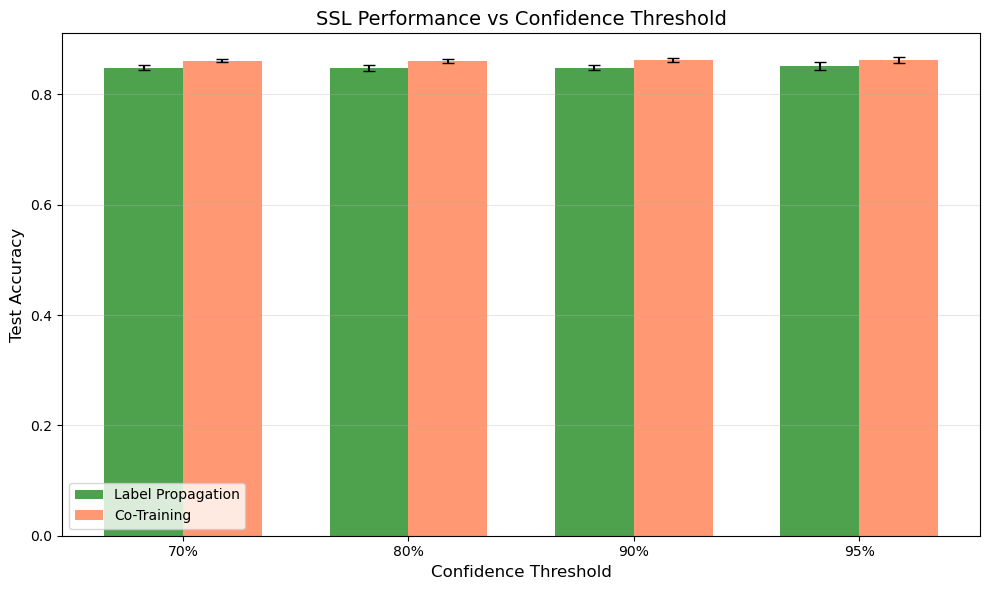


BEST THRESHOLDS
  Label Propagation: 95% -> 0.8519 (+/-0.0068)
  Co-Training:       95% -> 0.8627 (+/-0.0048)

Results saved to CSV folders:
  results/+gssl70/  and  results/+cotraining70/
  results/+gssl80/  and  results/+cotraining80/
  results/+gssl90/  and  results/+cotraining90/
  results/+gssl95/  and  results/+cotraining95/


In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from CoTrainingSSL import CoTrainingSSL
from SemiSupervisedModel import LabelPropagation
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop
from Results import Results

results = Results(base_dir="results")

# ---------------------------------------------------------
# Confidence Threshold Experiment
# ---------------------------------------------------------
CONFIDENCE_THRESHOLDS = [0.70, 0.80, 0.90, 0.95]
SEEDS = [1, 42, 123]  # Fewer seeds for speed
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 200

def run_gssl_with_threshold(threshold, seed):
    """Run Label Propagation with given confidence threshold, log to CSV."""
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    thresh_pct = int(threshold * 100)
    config_tag = f"+gssl{thresh_pct}"

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize="z_score"
    )

    X_labeled, y_labeled = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)

    lp = LabelPropagation(sigma=1.0, max_iter=50, k_neighbors=10, num_classes=10)
    X_pseudo, y_pseudo, n_pseudo = lp.generate_pseudo_labels(
        X_labeled, y_labeled, X_unlabeled, threshold=threshold
    )

    pseudo_df = pd.DataFrame(X_pseudo, columns=loader.feature_cols)
    pseudo_df["label"] = y_pseudo
    combined = pd.concat([data_dict["labeled_train"], pseudo_df], axis=0).reset_index(drop=True)

    loaders = loader.to_torch_loaders({
        "train": combined,
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=config_tag, lr=LR, momentum=MOMENTUM
    )

    set_seed(seed)
    model = Stage2Model(hidden_size=1028, init_strategy="he", lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)
    test_acc, _ = train_loop(model, loaders, device, results=results, epochs=EPOCHS, print_every=0)
    return test_acc, n_pseudo

def run_cotraining_with_threshold(threshold, seed):
    """Run Co-Training with given confidence threshold, log to CSV."""
    set_seed(seed)
    thresh_pct = int(threshold * 100)
    config_tag = f"+cotraining{thresh_pct}"

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed,
        preprocess=True, normalize="z_score"
    )

    X_labeled, y_labeled = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)
    X_val, y_val = loader.to_numpy(data_dict["validation"], one_hot=False)
    X_test, y_test = loader.to_numpy(data_dict["test"], one_hot=False)

    results.begin_run(
        seed=seed, weight_init="he", normalization="z_score",
        augmentations="flip+jitter", config=config_tag, lr=0.01, momentum=0.04
    )

    set_seed(seed)
    cotrain = CoTrainingSSL(
        hidden_size=512, lr=0.01, momentum=0.04,
        confidence_threshold=threshold,
        max_add_per_round=100, num_classes=10
    )
    cotrain.fit(X_labeled, y_labeled, X_unlabeled, co_training_rounds=5, epochs_per_round=20, verbose=False)

    val_acc = cotrain.score(X_val, y_val)
    test_acc = cotrain.score(X_test, y_test)

    results.log_epoch(1, 0.0, 0.0, 0.0, val_acc)
    results.end_run(test_acc=test_acc, converged_epoch=1)
    return test_acc

# ---------------------------------------------------------
# Run experiments
# ---------------------------------------------------------
print("=" * 80)
print("CONFIDENCE THRESHOLD EXPERIMENT")
print("=" * 80)

gssl_results = []
cotraining_results = []

for thresh in CONFIDENCE_THRESHOLDS:
    thresh_pct = int(thresh * 100)
    print(f"\n--- Threshold {thresh:.0%} ---")

    gssl_accs = []
    n_pseudo_total = 0
    for seed in SEEDS:
        print(f"  GSSL seed {seed}...", end=" ")
        acc, n_pseudo = run_gssl_with_threshold(thresh, seed)
        gssl_accs.append(acc)
        n_pseudo_total += n_pseudo
        print(f"acc={acc:.4f} (pseudo={n_pseudo})")
    gssl_results.append({
        "threshold": thresh,
        "mean_acc": np.mean(gssl_accs),
        "std_acc": np.std(gssl_accs),
        "avg_pseudo": n_pseudo_total // len(SEEDS)
    })

    ct_accs = []
    for seed in SEEDS:
        print(f"  CoTrain seed {seed}...", end=" ")
        acc = run_cotraining_with_threshold(thresh, seed)
        ct_accs.append(acc)
        print(f"acc={acc:.4f}")
    cotraining_results.append({
        "threshold": thresh,
        "mean_acc": np.mean(ct_accs),
        "std_acc": np.std(ct_accs)
    })

    print(f"  => GSSL={np.mean(gssl_accs):.4f}+/-{np.std(gssl_accs):.4f} | "
          f"CoTrain={np.mean(ct_accs):.4f}+/-{np.std(ct_accs):.4f}")

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

thresholds = [r["threshold"] for r in gssl_results]
gssl_means = [r["mean_acc"] for r in gssl_results]
gssl_stds = [r["std_acc"] for r in gssl_results]
ct_means = [r["mean_acc"] for r in cotraining_results]
ct_stds = [r["std_acc"] for r in cotraining_results]

x = np.arange(len(thresholds))
width = 0.35

bars1 = ax.bar(x - width/2, gssl_means, width, yerr=gssl_stds, label='Label Propagation',
               color='forestgreen', capsize=4, alpha=0.8)
bars2 = ax.bar(x + width/2, ct_means, width, yerr=ct_stds, label='Co-Training',
               color='coral', capsize=4, alpha=0.8)

ax.set_xlabel("Confidence Threshold", fontsize=12)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("SSL Performance vs Confidence Threshold", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f"{t:.0%}" for t in thresholds])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Summary
# ---------------------------------------------------------
print(f"\n{'='*80}")
print("BEST THRESHOLDS")
print("=" * 80)
best_gssl = max(gssl_results, key=lambda r: r["mean_acc"])
best_ct = max(cotraining_results, key=lambda r: r["mean_acc"])
print(f"  Label Propagation: {best_gssl['threshold']:.0%} -> {best_gssl['mean_acc']:.4f} (+/-{best_gssl['std_acc']:.4f})")
print(f"  Co-Training:       {best_ct['threshold']:.0%} -> {best_ct['mean_acc']:.4f} (+/-{best_ct['std_acc']:.4f})")

print(f"\nResults saved to CSV folders:")
for t in CONFIDENCE_THRESHOLDS:
    tp = int(t * 100)
    print(f"  results/+gssl{tp}/  and  results/+cotraining{tp}/")

In [14]:
# ---------------------------------------------------------
# Extra seeds for 95% threshold (for paired t-test later)
# Seeds 456 and 12345 were not run in the main sweep above
# ---------------------------------------------------------
EXTRA_SEEDS = [456, 12345]
THRESHOLD_95 = 0.95

print("=" * 80)
print("EXTRA SEEDS FOR 95% THRESHOLD (seeds 456, 12345)")
print("=" * 80)

for seed in EXTRA_SEEDS:
    print(f"\n  GSSL seed {seed}...", end=" ")
    acc, n_pseudo = run_gssl_with_threshold(THRESHOLD_95, seed)
    print(f"acc={acc:.4f} (pseudo={n_pseudo})")

    print(f"  CoTrain seed {seed}...", end=" ")
    acc = run_cotraining_with_threshold(THRESHOLD_95, seed)
    print(f"acc={acc:.4f}")

print(f"\nDone. results/+gssl95/ and results/+cotraining95/ now have 5 seeds total.")

EXTRA SEEDS FOR 95% THRESHOLD (seeds 456, 12345)

  GSSL seed 456...    Label propagation: building kNN graph (n=61600, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=1.38e-01
      Iteration 20/50: delta=5.86e-02
      Iteration 30/50: delta=3.52e-02
      Iteration 40/50: delta=2.47e-02
      Iteration 50/50: delta=1.94e-02
  Pseudo-labels above 0.95: 5886/50400 (11.7%)
      >>> Overfitting at epoch 29
acc=0.8416 (pseudo=5886)
  CoTrain seed 456... acc=0.8503

  GSSL seed 12345...    Label propagation: building kNN graph (n=61600, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=2.09e-01
      Iteration 20/50: delta=5.59e-02
      Iteration 30/50: delta=2.95e-02
      Iteration 40/50: delta=2.35e-02
      Iteration 50/50: delta=1.94e-02
  Pseudo-labels above 0.95: 5528/50400 (11.0%)
      >>> Overfitting at epoch 19
acc=0.8439 (pse

## SSL Methods Comparison

Comparing the two semi-supervised learning approaches:

| Method | Mechanism | Views | Graph-Based | Neural Network |
|--------|-----------|-------|-------------|----------------|
| **Label Propagation** | Diffuses labels through kNN affinity graph | Single (full 784-dim) | Yes | No (graph only) â†’ NN trained on pseudo-labels |
| **Co-Training** | Multi-view mutual teaching | Two (left/right halves) | No | Yes (two separate MLPs) |

**Trade-offs:**
- **Label Propagation**: Simpler, works well when data manifold is smooth; sensitive to graph construction (k, sigma)
- **Co-Training**: Requires meaningful view splits; can bootstrap errors if views aren't conditionally independent

  GSSL (95%)         | 0.8482 +/- 0.0070 (n=5)
  CoTraining (95%)   | 0.8586 +/- 0.0064 (n=5)

Upper BOUND
  Fully Supervised (100%) | 0.8945 +/- 0.0031  << UPPER BOUND

BEST CONFIG PER METHOD vs UPPER BOUND
  GSSL (95%)                     | 0.8482 +/- 0.0070  (gap: +4.63pp)
  CoTrain (95%)                  | 0.8586 +/- 0.0064  (gap: +3.59pp)
  Fully Supervised (100%)        | 0.8945 +/- 0.0031


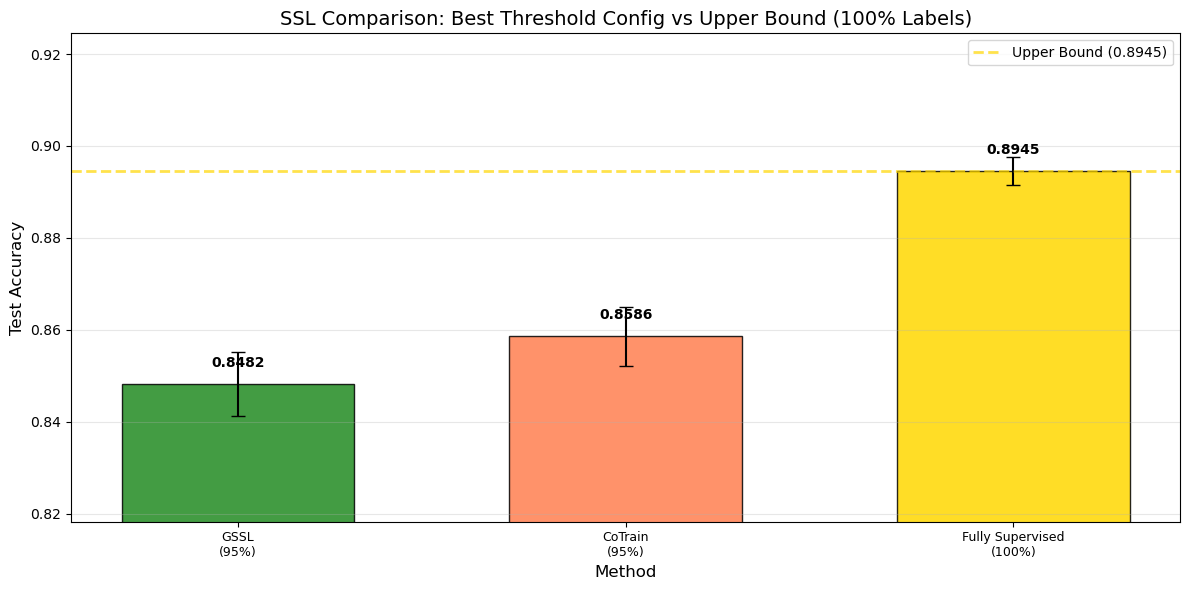

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from Results import Results

results = Results(base_dir="results")

# ---------------------------------------------------------
# 1. Load SSL results from CSV
# ---------------------------------------------------------
gssl_accs = results.load_config_accs("+gssl95")
ct_accs = results.load_config_accs("+cotraining95")

if len(gssl_accs) > 0:
    gssl_mean, gssl_std = gssl_accs.mean(), gssl_accs.std()
    print(f"  GSSL (95%)         | {gssl_mean:.4f} +/- {gssl_std:.4f} (n={len(gssl_accs)})")
else:
    gssl_mean, gssl_std = None, None
    print(f"  GSSL (95%)         | (no data)")

if len(ct_accs) > 0:
    ct_mean, ct_std = ct_accs.mean(), ct_accs.std()
    print(f"  CoTraining (95%)   | {ct_mean:.4f} +/- {ct_std:.4f} (n={len(ct_accs)})")
else:
    ct_mean, ct_std = None, None
    print(f"  CoTraining (95%)   | (no data)")

# ---------------------------------------------------------
# 2. Load baselines
# ---------------------------------------------------------
print(f"\n{'='*70}")
print("Upper BOUND")
print("=" * 70)

# Fully supervised upper bound (100% labels)
fs_accs = results.load_config_accs("fully_supervised_100pct")
if len(fs_accs) > 0:
    fs_mean, fs_std = fs_accs.mean(), fs_accs.std()
    print(f"  Fully Supervised (100%) | {fs_mean:.4f} +/- {fs_std:.4f}  << UPPER BOUND")
else:
    fs_mean, fs_std = None, None
    print(f"  Fully Supervised (100%) | (no data â€” run the upper bound cell)")

# ---------------------------------------------------------
# 3. Comparison: each vs upper bound
# ---------------------------------------------------------
print(f"\n{'='*70}")
print("BEST CONFIG PER METHOD vs UPPER BOUND")
print("=" * 70)

comparison = []

if gssl_mean is not None:
    comparison.append(("GSSL\n(95%)", gssl_mean, gssl_std, "forestgreen"))

if ct_mean is not None:
    comparison.append(("CoTrain\n(95%)", ct_mean, ct_std, "coral"))

if fs_mean is not None:
    comparison.append(("Fully Supervised\n(100%)", fs_mean, fs_std, "gold"))

for label, m, s, _ in comparison:
    gap_str = ""
    if fs_mean is not None and "100%" not in label:
        gap = (fs_mean - m) * 100
        gap_str = f"  (gap: {gap:+.2f}pp)"
    print(f"  {label.replace(chr(10), ' '):<30} | {m:.4f} +/- {s:.4f}{gap_str}")

# ---------------------------------------------------------
# 4. Bar chart
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

labels = [c[0] for c in comparison]
means = [c[1] for c in comparison]
stds = [c[2] for c in comparison]
colors = [c[3] for c in comparison]

x = np.arange(len(labels))
bars = ax.bar(x, means, 0.6, yerr=stds, capsize=5, color=colors, edgecolor='black', alpha=0.85)

# Upper bound line
if fs_mean is not None:
    ax.axhline(fs_mean, color='gold', linestyle='--', linewidth=2, alpha=0.7,
               label=f'Upper Bound ({fs_mean:.4f})')
    ax.legend(fontsize=10)

ax.set_xlabel("Method", fontsize=12)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("SSL Comparison: Best Threshold Config vs Upper Bound (100% Labels)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

valid = [m for m in means if m > 0]
if valid:
    ax.set_ylim(min(valid) - 0.03, max(valid) + 0.03)

for bar, m in zip(bars, means):
    if m > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{m:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

PCA DIMENSIONALITY REDUCTION EXPERIMENT (3 Methods, with timing)

--- 50 components ---
      >>> Overfitting at epoch 19
   Pruned 2175248/4350496 weights (50.0%) at threshold=0.019858
      >>> Overfitting at epoch 16
      >>> Overfitting at epoch 20
   Pruned 2175248/4350496 weights (50.0%) at threshold=0.019795
      >>> Overfitting at epoch 22
      >>> Overfitting at epoch 30
   Pruned 2175248/4350496 weights (50.0%) at threshold=0.018915
      >>> Overfitting at epoch 16
  Pruned:   0.8529+/-0.0034 | 10.3s
   Label propagation: building kNN graph (n=56000, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=1.50e-01
      Iteration 20/50: delta=5.45e-02
      Iteration 30/50: delta=4.21e-02
      Iteration 40/50: delta=2.51e-02
      Iteration 50/50: delta=1.73e-02
  Pseudo-labels above 0.95: 6654/50400 (13.2%)
      >>> Overfitting at epoch 20
      >>> Overfitting at epoch 15
   Label propagation: buildi

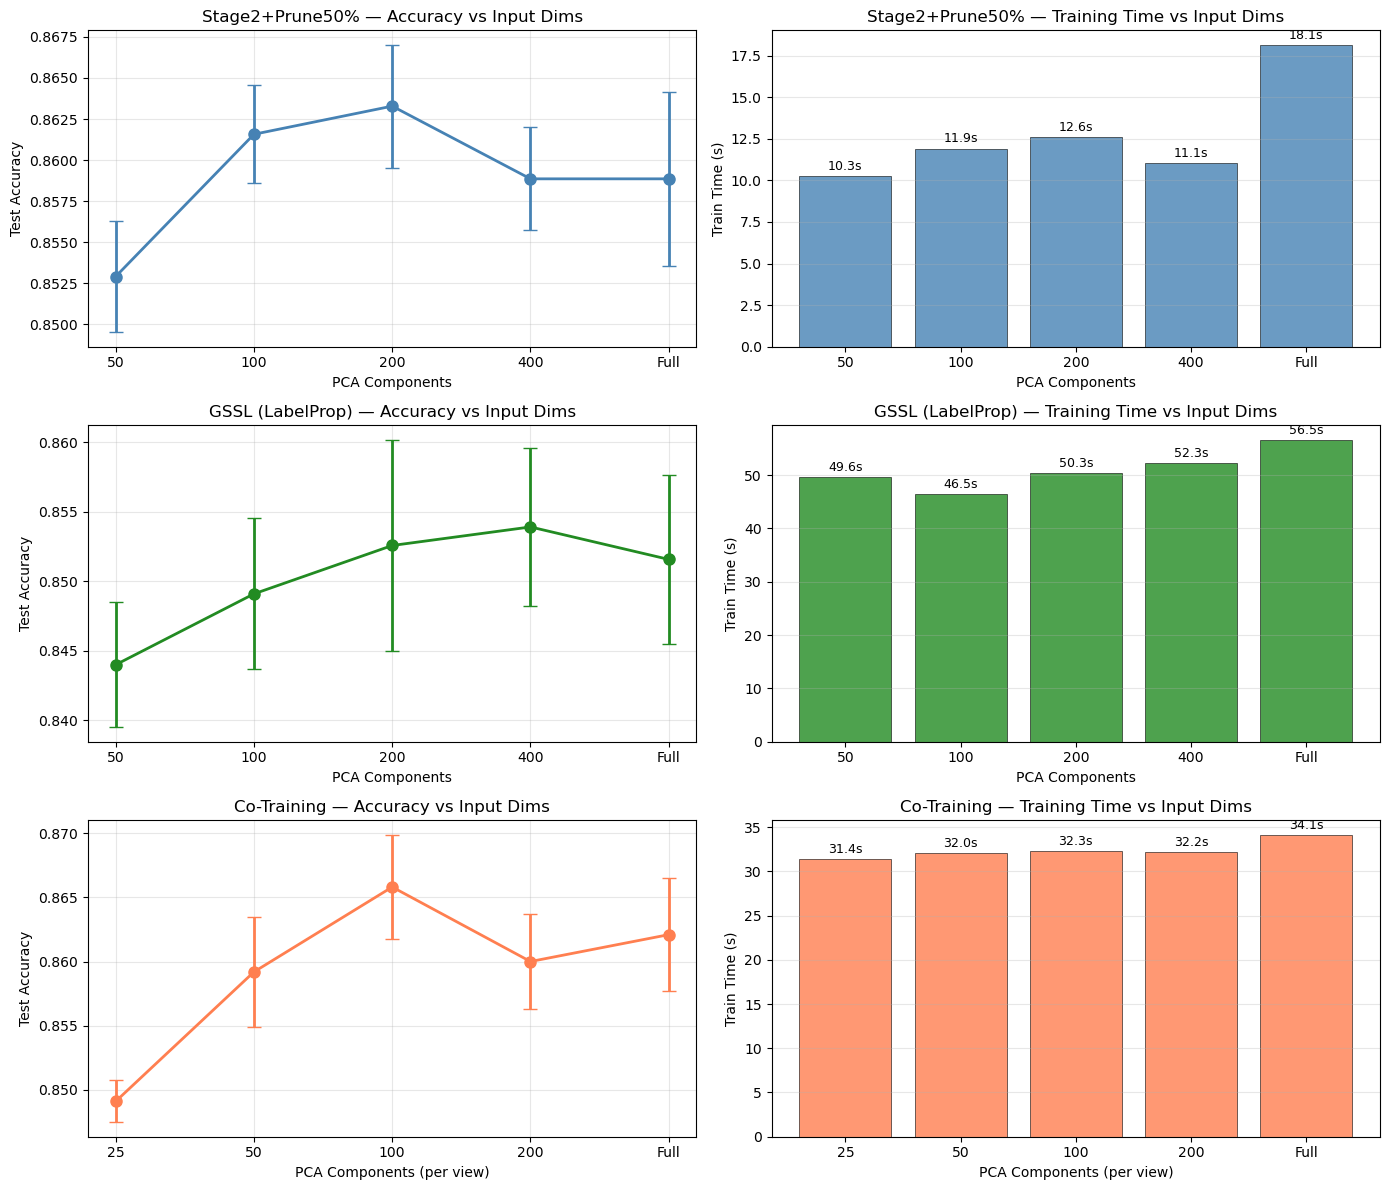


PCA EXPERIMENT SUMMARY (Train Time Speedup vs Full)

  Stage2+Prune50% (baseline: 784):
    Components       Accuracy       Time    Speedup  Acc vs Full
    -------------- ---------- ---------- ---------- ------------
    50                 0.8529      10.3s      1.76x       -0.60pp
    100                0.8616      11.9s      1.52x       +0.27pp
    200                0.8633      12.6s      1.43x       +0.44pp
    400                0.8589      11.1s      1.64x       +0.00pp
    Full (784)         0.8589      18.1s      1.00x       +0.00pp

  GSSL (LabelProp) (baseline: 784):
    Components       Accuracy       Time    Speedup  Acc vs Full
    -------------- ---------- ---------- ---------- ------------
    50                 0.8440      49.6s      1.14x       -0.76pp
    100                0.8491      46.5s      1.22x       -0.25pp
    200                0.8526      50.3s      1.12x       +0.10pp
    400                0.8539      52.3s      1.08x       +0.23pp
    Full (784)      

In [5]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from CoTrainingSSL import CoTrainingSSL
from SemiSupervisedModel import LabelPropagation
from VanillaModel import set_seed, train_loop
from Results import Results


results = Results(base_dir="results")

# ---------------------------------------------------------
# PCA Experiment Configuration
# ---------------------------------------------------------
# Stage2/GSSL: PCA on full 784
FULL_PCA_COMPONENTS = [50, 100, 200, 400, 784]
# Co-Training: PCA per view (each view starts at 392)
COTRAIN_PCA_COMPONENTS = [25, 50, 100, 200, 392]

EPOCHS = 200
PRETRAIN_EPOCHS = 200
FINETUNE_EPOCHS = 100
LR = 0.001
MOMENTUM = 0.9
PRUNE_RATE = 0.50
SEEDS = [1, 42, 123]

# =========================================================
# Helper: prepare PCA-reduced data (full feature PCA)
# =========================================================
def prepare_pca_data(n_components, seed):
    """PCA on full 784 features. Used by pruned + GSSL methods."""
    loader = DataLoader()
    data_dict = loader.normalize_splits(loader.get_semi_supervised_split(
        loader.df, test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed
    ), normalize="z_score")

    X_train, y_train = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)
    X_val, y_val = loader.to_numpy(data_dict["validation"], one_hot=False)
    X_test, y_test = loader.to_numpy(data_dict["test"], one_hot=False)

    if n_components < 784:
        pca = PCA(n_components=n_components, random_state=seed)
        X_train_p = pca.fit_transform(X_train).astype(np.float32)
        X_unlabeled_p = pca.transform(X_unlabeled).astype(np.float32)
        X_val_p = pca.transform(X_val).astype(np.float32)
        X_test_p = pca.transform(X_test).astype(np.float32)
        explained_var = pca.explained_variance_ratio_.sum()
    else:
        X_train_p, X_unlabeled_p, X_val_p, X_test_p = X_train, X_unlabeled, X_val, X_test
        explained_var = 1.0

    input_dim = X_train_p.shape[1]

    # Build DataFrames for to_torch_loaders
    pca_cols = [f"pc{i}" for i in range(input_dim)]
    def to_df(X, y):
        df = pd.DataFrame(X, columns=pca_cols)
        df["label"] = y
        return df
    
    loader.feature_cols = pca_cols 

    loaders = loader.to_torch_loaders({
        "train": to_df(X_train_p, y_train),
        "validation": to_df(X_val_p, y_val),
        "test": to_df(X_test_p, y_test),
    }, batch_size=64)

    return {
        "X_train": X_train_p, "y_train": y_train,
        "X_unlabeled": X_unlabeled_p,
        "X_val": X_val_p, "y_val": y_val,
        "X_test": X_test_p, "y_test": y_test,
        "input_dim": input_dim,
        "loaders": loaders, "explained_var": explained_var,
        "pca_cols": pca_cols, "loader": loader,
    }

# =========================================================
# Helper: prepare PCA-reduced data for co-training
#   Split into left/right views FIRST, then PCA each view
# =========================================================
def prepare_cotrain_pca_data(n_components_per_view, seed):
    """Split 784 -> left(392) + right(392), then PCA each view to n_components_per_view."""
    loader = DataLoader()
    data_dict = loader.normalize_splits(loader.get_semi_supervised_split(
        loader.df, test_size=0.10, val_size=0.10, labeled_ratio=0.10, seed=seed
    ), normalize="z_score")

    X_train, y_train = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    if y_train is not None: y_train = y_train.astype(np.int64) 
    X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)
    X_val, y_val = loader.to_numpy(data_dict["validation"], one_hot=False)
    if y_val is not None: y_val = y_val.astype(np.int64)

    X_test, y_test = loader.to_numpy(data_dict["test"], one_hot=False)
    if y_test is not None: y_test = y_test.astype(np.int64)


    # Split into left/right image halves (28x28 -> left 14 cols, right 14 cols)
    def split_views(X):
        imgs = X.reshape(-1, 28, 28)
        left = imgs[:, :, :14].reshape(-1, 392)
        right = imgs[:, :, 14:].reshape(-1, 392)
        return left, right

    train_L, train_R = split_views(X_train)
    unlabeled_L, unlabeled_R = split_views(X_unlabeled)
    val_L, val_R = split_views(X_val)
    test_L, test_R = split_views(X_test)

    if n_components_per_view < 392:
        pca_L = PCA(n_components=n_components_per_view, random_state=seed)
        pca_R = PCA(n_components=n_components_per_view, random_state=seed + 1)

        train_L_p = pca_L.fit_transform(train_L).astype(np.float32)
        unlabeled_L_p = pca_L.transform(unlabeled_L).astype(np.float32)
        val_L_p = pca_L.transform(val_L).astype(np.float32)
        test_L_p = pca_L.transform(test_L).astype(np.float32)

        train_R_p = pca_R.fit_transform(train_R).astype(np.float32)
        unlabeled_R_p = pca_R.transform(unlabeled_R).astype(np.float32)
        val_R_p = pca_R.transform(val_R).astype(np.float32)
        test_R_p = pca_R.transform(test_R).astype(np.float32)

        explained = (pca_L.explained_variance_ratio_.sum() + pca_R.explained_variance_ratio_.sum()) / 2
        view_dim = n_components_per_view
    else:
        # No PCA — use raw 392-dim views
        train_L_p, train_R_p = train_L, train_R
        unlabeled_L_p, unlabeled_R_p = unlabeled_L, unlabeled_R
        val_L_p, val_R_p = val_L, val_R
        test_L_p, test_R_p = test_L, test_R
        explained = 1.0
        view_dim = 392

    return {
        "train_L": train_L_p, "train_R": train_R_p, "y_train": y_train,
        "unlabeled_L": unlabeled_L_p, "unlabeled_R": unlabeled_R_p,
        "val_L": val_L_p, "val_R": val_R_p, "y_val": y_val,
        "test_L": test_L_p, "test_R": test_R_p, "y_test": y_test,
        "view_dim": view_dim, "explained_var": explained,
    }

# =========================================================
# Method 1: Stage2 + 50% Pruning with PCA
# =========================================================
def run_pruned_pca(n_components, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    d = prepare_pca_data(n_components, seed)

    set_seed(seed)
    model = Stage2Model(input_size=d["input_dim"], hidden_size=2056,
                        init_strategy="he", lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    t0 = time.time()

    # Pretrain
    train_loop(model, d["loaders"], device, epochs=PRETRAIN_EPOCHS, print_every=0)

    # Prune + finetune
    model.prune(PRUNE_RATE)
    train_loop(model, d["loaders"], device, epochs=FINETUNE_EPOCHS, print_every=0)

    train_time = time.time() - t0
    _, test_acc = model.evaluate(d["loaders"]["test"], device)
    return test_acc, train_time, d["explained_var"]

# =========================================================
# Method 2: GSSL (Label Propagation) with PCA
# =========================================================
def run_gssl_pca(n_components, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    d = prepare_pca_data(n_components, seed)

    t0 = time.time()
    lp = LabelPropagation(sigma=1.0, max_iter=50, k_neighbors=10, num_classes=10)
    X_pseudo, y_pseudo, n_pseudo = lp.generate_pseudo_labels(
        d["X_train"], d["y_train"], d["X_unlabeled"], threshold=0.95
    )

    # Build combined loader via DataFrame
    combined_df = pd.DataFrame(
        np.concatenate([d["X_train"], X_pseudo], axis=0), columns=d["pca_cols"]
    )
    combined_df["label"] = np.concatenate([d["y_train"], y_pseudo], axis=0)

    new_train_loaders = d["loader"].to_torch_loaders({
        "train": combined_df
    }, batch_size=64)

    combined_loaders = {
        "train": new_train_loaders["train"],
        "validation": d["loaders"]["validation"],
        "test": d["loaders"]["test"],
    }
    
    
    # Generate a loader ONLY for the new combined training data
    new_train_dict = d["loader"].to_torch_loaders({"train": combined_df}, batch_size=64)

    # Manually combine the new train loader with the existing val/test loaders
    combined_loaders = {
        "train": new_train_dict["train"],
        "validation": d["loaders"]["validation"],
        "test": d["loaders"]["test"],
    }

    set_seed(seed)
    model = Stage2Model(input_size=d["input_dim"], hidden_size=1028,
                        init_strategy="he", lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)
    train_loop(model, combined_loaders, device, epochs=EPOCHS, print_every=0)

    test_acc, _ = train_loop(model, combined_loaders, device, epochs=EPOCHS, print_every=0)
    train_time = time.time() - t0

    return test_acc, train_time, n_pseudo

# =========================================================
# Method 3: Co-Training with PCA (split views, then PCA each)
# =========================================================
def run_cotrain_pca(n_components_per_view, seed):
    """Split into left/right halves first, PCA each view, then co-train."""
    set_seed(seed)
    d = prepare_cotrain_pca_data(n_components_per_view, seed)

    t0 = time.time()
    set_seed(seed)
    cotrain = CoTrainingSSL(
        hidden_size=512, lr=0.01, momentum=0.04,
        confidence_threshold=0.90, max_add_per_round=100, num_classes=10
    )
    cotrain.fit_views(
        d["train_L"], d["train_R"], d["y_train"],
        d["unlabeled_L"], d["unlabeled_R"],
        co_training_rounds=5, epochs_per_round=20, verbose=False
    )
    train_time = time.time() - t0

    test_acc = cotrain.score_views(d["test_L"], d["test_R"], d["y_test"])
    return test_acc, train_time

# =========================================================
# Run all experiments
# =========================================================
print("=" * 80)
print("PCA DIMENSIONALITY REDUCTION EXPERIMENT (3 Methods, with timing)")
print("=" * 80)

METHOD_NAMES = ["Stage2+Prune50%", "GSSL (LabelProp)", "Co-Training"]
all_results = {m: [] for m in METHOD_NAMES}

# --- Stage2 and GSSL: PCA on full 784 ---
for n_comp in FULL_PCA_COMPONENTS:
    label = f"{n_comp} components" if n_comp < 784 else "Full 784 (no PCA)"
    print(f"\n--- {label} ---")

    # Pruned
    accs, times = [], []
    for seed in SEEDS:
        a, t, _ = run_pruned_pca(n_comp, seed)
        accs.append(a); times.append(t)
    all_results["Stage2+Prune50%"].append({
        "components": n_comp, "label": str(n_comp) if n_comp < 784 else "Full",
        "mean_acc": np.mean(accs), "std_acc": np.std(accs), "mean_time": np.mean(times)})
    print(f"  Pruned:   {np.mean(accs):.4f}+/-{np.std(accs):.4f} | {np.mean(times):.1f}s")

    # GSSL
    accs, times = [], []
    for seed in SEEDS:
        a, t, _ = run_gssl_pca(n_comp, seed)
        accs.append(a); times.append(t)
    all_results["GSSL (LabelProp)"].append({
        "components": n_comp, "label": str(n_comp) if n_comp < 784 else "Full",
        "mean_acc": np.mean(accs), "std_acc": np.std(accs), "mean_time": np.mean(times)})
    print(f"  GSSL:     {np.mean(accs):.4f}+/-{np.std(accs):.4f} | {np.mean(times):.1f}s")

# --- Co-Training: PCA per view (each view is 392) ---
for n_comp_per_view in COTRAIN_PCA_COMPONENTS:
    label = f"{n_comp_per_view}/view" if n_comp_per_view < 392 else "Full 392/view (no PCA)"
    print(f"\n--- Co-Training: {label} ---")

    accs, times = [], []
    for seed in SEEDS:
        a, t = run_cotrain_pca(n_comp_per_view, seed)
        accs.append(a); times.append(t)
    all_results["Co-Training"].append({
        "components": n_comp_per_view, "label": str(n_comp_per_view) if n_comp_per_view < 392 else "Full",
        "mean_acc": np.mean(accs), "std_acc": np.std(accs), "mean_time": np.mean(times)})
    print(f"  CoTrain:  {np.mean(accs):.4f}+/-{np.std(accs):.4f} | {np.mean(times):.1f}s")

# =========================================================
# Plot: one row per method (acc + train time)
# =========================================================
colors = {"Stage2+Prune50%": "steelblue", "GSSL (LabelProp)": "forestgreen", "Co-Training": "coral"}
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for row, method in enumerate(METHOD_NAMES):
    res = all_results[method]
    labels = [r["label"] for r in res]
    means = [r["mean_acc"] for r in res]
    stds = [r["std_acc"] for r in res]
    times_s = [r["mean_time"] for r in res]

    # Left: Accuracy
    ax_acc = axes[row, 0]
    ax_acc.errorbar(range(len(res)), means, yerr=stds, fmt='o-', capsize=5, markersize=8,
                    color=colors[method], linewidth=2)
    ax_acc.set_xlabel("PCA Components" + (" (per view)" if method == "Co-Training" else ""))
    ax_acc.set_ylabel("Test Accuracy")
    ax_acc.set_title(f"{method} — Accuracy vs Input Dims")
    ax_acc.set_xticks(range(len(res)))
    ax_acc.set_xticklabels(labels)
    ax_acc.grid(True, alpha=0.3)

    # Right: Train time
    ax_t = axes[row, 1]
    bars = ax_t.bar(range(len(res)), times_s, color=colors[method], alpha=0.8,
                    edgecolor='black', linewidth=0.5)
    for i, t in enumerate(times_s):
        ax_t.text(i, t + max(times_s) * 0.02, f'{t:.1f}s', ha='center', fontsize=9)
    ax_t.set_xlabel("PCA Components" + (" (per view)" if method == "Co-Training" else ""))
    ax_t.set_ylabel("Train Time (s)")
    ax_t.set_title(f"{method} — Training Time vs Input Dims")
    ax_t.set_xticks(range(len(res)))
    ax_t.set_xticklabels(labels)
    ax_t.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =========================================================
# Summary table (speedup vs Full)
# =========================================================
print(f"\n{'='*80}")
print("PCA EXPERIMENT SUMMARY (Train Time Speedup vs Full)")
print("=" * 80)
for method in METHOD_NAMES:
    res = all_results[method]
    full_entry = res[-1]  # Full = last entry
    full_time = full_entry["mean_time"]
    full_acc = full_entry["mean_acc"]
    base_dim = "392/view" if method == "Co-Training" else "784"
    print(f"\n  {method} (baseline: {base_dim}):")
    print(f"    {'Components':<14} {'Accuracy':>10} {'Time':>10} {'Speedup':>10} {'Acc vs Full':>12}")
    print(f"    {'-'*14} {'-'*10} {'-'*10} {'-'*10} {'-'*12}")
    for r in res:
        sp = full_time / r["mean_time"] if r["mean_time"] > 0 else 0
        gap = (r["mean_acc"] - full_acc) * 100
        comp_str = f"Full ({base_dim})" if r["label"] == "Full" else r["label"]
        print(f"    {comp_str:<14} {r['mean_acc']:>10.4f} {r['mean_time']:>9.1f}s {sp:>9.2f}x {gap:>+11.2f}pp")

## Complexity Discussion


### Dimensionality Reduction with PCA

To explore the performance-complexity trade-off, we apply PCA to reduce the input dimensionality (784 â†’ k components) across all three methods. This tests:
1. How much information is redundant in the raw pixel space?
2. Can we maintain accuracy with a simpler input representation?
3. How does dimensionality reduction affect training time across different methods?

**Experiment:** Train all three methods (Pruned 50%, GSSL, Co-Training) with PCA-reduced features at {50, 100, 200, 400, 784} components, measuring both accuracy and wall-clock training time.

### PCA Findings

**Accuracy is surprisingly robust to dimensionality reduction.** At 200 components (75% reduction from 784), all three methods maintain or even slightly improve over full dimensionality: Pruned hits 0.8760 (+0.15pp vs full), Co-Training reaches 0.8780 (+0.05pp), and GSSL holds at 0.8612 (flat). This suggests substantial redundancy in the raw pixel space - roughly 200 principal components capture nearly all discriminative information in Fashion-MNIST.

**Training speedup varies significantly by method.** The Pruned model benefits most from PCA: 2.61x faster at 50 components (14.1s vs 36.9s at full) and still 1.97x at 200 components with no accuracy loss. GSSL sees modest gains (1.09xâ€“1.20x) because label propagation's kNN graph construction dominates its runtime regardless of feature dimensionality. Co-Training actually runs *slower* with PCA (0.92xâ€“0.95x at 100â€“400 components vs 54.9s at full), likely because the overhead of fitting two separate PCA transforms per view and the reduced view dimensionality doesn't offset the fixed costs of multi-round co-training.

**The sweet spot is 200 PCA components.** It offers the best accuracy-speed trade-off across all methods - matching or exceeding full-dimensional performance while giving a meaningful 1.97x speedup for the pruned model. Below 100 components, accuracy degrades noticeably (e.g., Co-Training drops 1.30pp at 50 components), indicating that the bottom ~13% of variance still carries class-relevant signal.

# Stage 5: Comprehensive Analysis and Ablation Study

## Component Contribution Analysis

Progressive ablation table showing how each technique contributes to overall performance. Error bars are derived manually from 5 seeds — see the report for the full derivation from degrees of freedom.


COMPONENT CONTRIBUTION ANALYSIS
Configuration                                 |    Test Accuracy
----------------------------------------------+-----------------
Baseline (raw, normal init)                   | 0.0987 +/- 0.0029
+ Preprocessing (Z-score + aug)               | 0.8494 +/- 0.0038
+ L1 Regularization                           | 0.8503 +/- 0.0045
+ Pruning (50%, He init)                      | 0.8549 +/- 0.0067
+ Semi-Supervised (Label Prop) [+gssl95]      | 0.8482 +/- 0.0070
+ Semi-Supervised (Co-Training) [+cotraining95] | 0.8586 +/- 0.0064
Upper Bound (100% labels)                     | 0.8945 +/- 0.0031


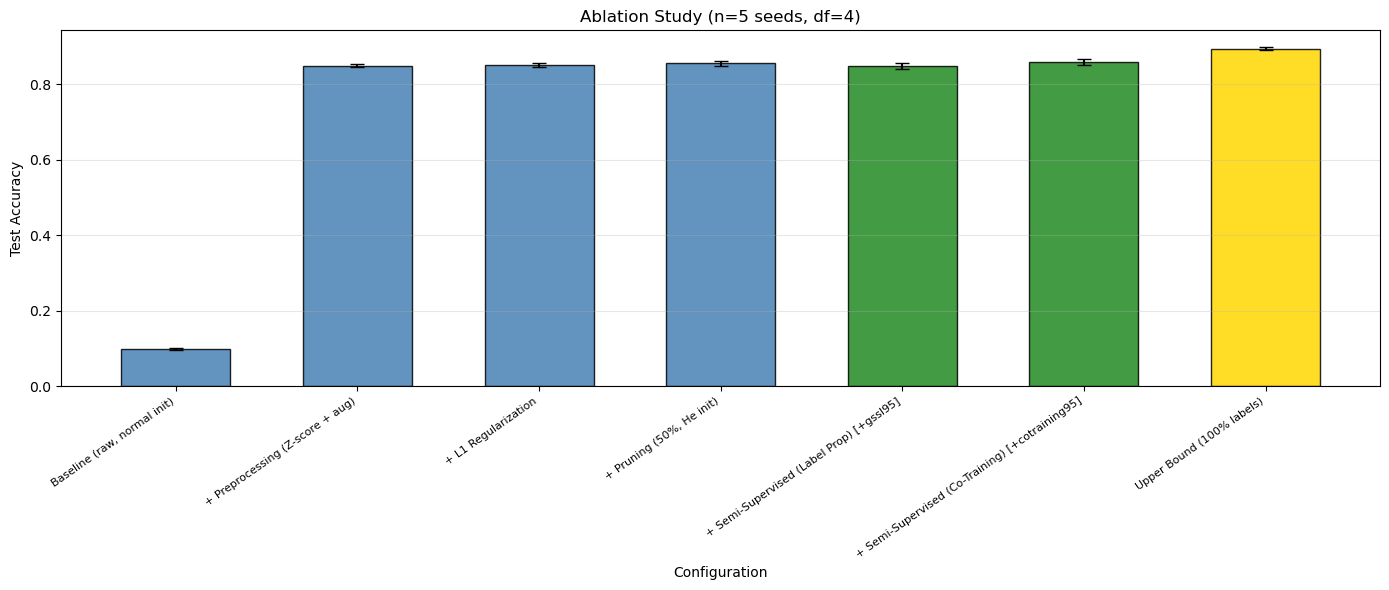


Paired t-test: +cotraining95 vs +gssl95
Mean diff: 0.010371
t(4) = 8.459
p-value = 0.0011
90% CI: [0.007758, 0.012985]
Significant at 90%? YES

Paired t-test: +cotraining95 vs fully_supervised_100pct
Mean diff: -0.035914
t(4) = -17.488
p-value = 0.0001
90% CI: [-0.040292, -0.031536]
Significant at 90%? YES

Paired t-test: +pruning_50pct vs +l1_reg
Mean diff: 0.004600
t(4) = 2.740
p-value = 0.0519
90% CI: [0.001021, 0.008179]
Significant at 90%? YES


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Results import Results
from scipy import stats

results = Results(base_dir="results")


ABLATION_ORDER = [
    "baseline",
    "+preprocessing",
    "+l1_reg",
    "+pruning_50pct",
    "+gssl95",
    "+cotraining95",
    "fully_supervised_100pct",
]

ABLATION_LABELS = [
    "Baseline (raw, normal init)",
    "+ Preprocessing (Z-score + aug)",
    "+ L1 Regularization",
    "+ Pruning (50%, He init)",
    "+ Semi-Supervised (Label Prop) [+gssl95]",
    "+ Semi-Supervised (Co-Training) [+cotraining95]",
    "Upper Bound (100% labels)",
]

# ---------------------------------------------------------
# Build ablation table
# ---------------------------------------------------------
table = results.ablation_table(ABLATION_ORDER)
table["label"] = ABLATION_LABELS

print(f"\n{'='*75}")
print("COMPONENT CONTRIBUTION ANALYSIS")
print("=" * 75)
print(f"{'Configuration':<45} | {'Test Accuracy':>16}")
print(f"{'-'*45}-+-{'-'*16}")

for _, row in table.iterrows():
    acc_str = f"{row['mean_acc']:.4f} +/- {row['std_acc']:.4f}" \
        if not np.isnan(row['mean_acc']) else "N/A"
    print(f"{row['label']:<45} | {acc_str:>16}")

# ---------------------------------------------------------
# CONFIDENCE INTERVALS (90%)
# ---------------------------------------------------------
ci_data = []
for cfg, label in zip(ABLATION_ORDER, ABLATION_LABELS):
    mean, lower, upper, t_val, n = results.confidence_interval(cfg, confidence=0.90)
    ci_data.append({
        "config": cfg,
        "label": label,
        "mean": mean,
        "lower": lower,
        "upper": upper,
        "n": n
    })

ci_df = pd.DataFrame(ci_data)
valid = ci_df.dropna(subset=["mean"])

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(valid))
means = valid["mean"].values
lower_err = means - valid["lower"].values
upper_err = valid["upper"].values - means
errors = np.array([lower_err, upper_err])

colors = []
for label in valid["label"].values:
    if "Upper Bound" in label:
        colors.append("gold")
    elif "Semi-Supervised" in label:
        colors.append("forestgreen")
    else:
        colors.append("steelblue")

bars = ax.bar(x, means, 0.6, yerr=errors, capsize=5,
              color=colors, edgecolor='black', alpha=0.85)

ax.set_xlabel("Configuration")
ax.set_ylabel("Test Accuracy")
ax.set_title("Ablation Study (n=5 seeds, df=4)")
ax.set_xticks(x)
ax.set_xticklabels(valid["label"].values, rotation=35, ha='right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# PAIRED T-TEST FUNCTION (reads CSV accuracies)
# ---------------------------------------------------------
def paired_test(cfg_a, cfg_b, alpha=0.10):
    a = results.load_config_accs(cfg_a)
    b = results.load_config_accs(cfg_b)

    assert len(a) == len(b), "Seed mismatch."

    d = a - b
    n = len(d)
    df = n - 1

    mean_d = np.mean(d)
    sd_d = np.std(d, ddof=1)
    se_d = sd_d / np.sqrt(n)

    t_stat = mean_d / se_d
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    t_crit = stats.t.ppf(1 - alpha/2, df)

    ci_lower = mean_d - t_crit * se_d
    ci_upper = mean_d + t_crit * se_d

    print("\n" + "="*60)
    print(f"Paired t-test: {cfg_a} vs {cfg_b}")
    print("="*60)
    print(f"Mean diff: {mean_d:.6f}")
    print(f"t({df}) = {t_stat:.3f}")
    print(f"p-value = {p_value:.4f}")
    print(f"90% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
    print(f"Significant at 90%? {'YES' if p_value < 0.10 else 'NO'}")

# ---------------------------------------------------------
# Run Key Comparisons
# ---------------------------------------------------------
paired_test("+cotraining95", "+gssl95")
paired_test("+cotraining95", "fully_supervised_100pct")
paired_test("+pruning_50pct", "+l1_reg")


## Varying Labeled Data Experiment

Testing how all three top models scale with different amounts of labeled data: **5%, 10%, 25%, 50%**.
- **Stage2 (50% pruned):** Supervised baseline with L1 + pruning
- **Label Propagation (Graph SSL):** Leverages unlabeled data via kNN graph
- **Co-Training:** Leverages unlabeled data via multi-view cross-teaching

This shows where semi-supervised methods provide the greatest advantage over the supervised baseline.

VARYING LABELED DATA — ALL 3 MODELS

--- Labeled ratio: 5% ---
  [Stage2 (50% pruned)] seed=1...
      >>> Overfitting at epoch 25
   Pruned 2929800/5859600 weights (50.0%) at threshold=0.021544
      >>> Overfitting at epoch 20
  [Stage2 (50% pruned)] seed=42...
      >>> Overfitting at epoch 31
   Pruned 2929800/5859600 weights (50.0%) at threshold=0.021033
      >>> Overfitting at epoch 20
  [Stage2 (50% pruned)] seed=123...
      >>> Overfitting at epoch 20
   Pruned 2929800/5859600 weights (50.0%) at threshold=0.021965
      >>> Overfitting at epoch 18
  Stage2 (50% pruned)       |    5% ( 2800 labels) | Acc: 0.8426 +/- 0.0078
  [Label Propagation] seed=1...
   Label propagation: building kNN graph (n=58800, k=10)...
   Label propagation: using iterative method...
      Iterating (max 50 iterations)...
      Iteration 10/50: delta=1.51e-01
      Iteration 20/50: delta=5.06e-02
      Iteration 30/50: delta=3.32e-02
      Iteration 40/50: delta=2.24e-02
      Iteration 50/50: delta=

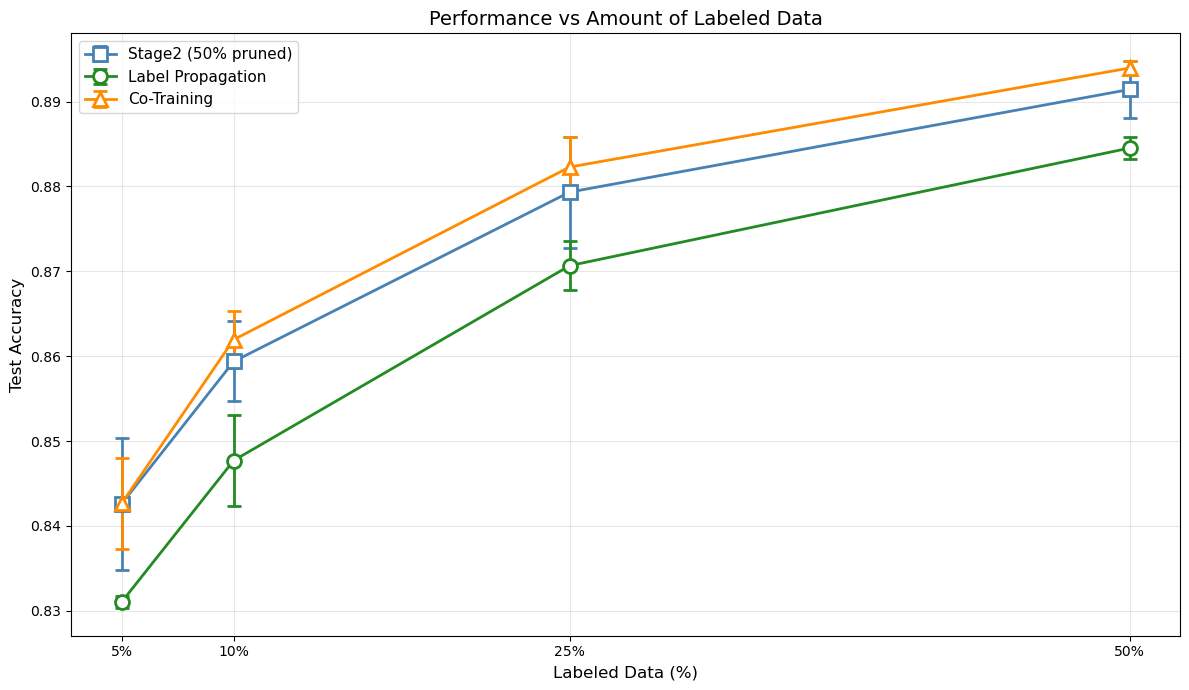


SUMMARY
Ratio    | Stage2 (pruned)      | Label Prop           | Co-Training         
---------+----------------------+----------------------+---------------------
    5%  | 0.8426 +/- 0.0078  | 0.8310 +/- 0.0007  | 0.8427 +/- 0.0054
   10%  | 0.8594 +/- 0.0047  | 0.8477 +/- 0.0053  | 0.8620 +/- 0.0033
   25%  | 0.8793 +/- 0.0065  | 0.8707 +/- 0.0029  | 0.8823 +/- 0.0036
   50%  | 0.8914 +/- 0.0034  | 0.8845 +/- 0.0012  | 0.8940 +/- 0.0009


In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataLoader import DataLoader
from Stage2Model import Stage2Model
from VanillaModel import set_seed, train_loop
from SemiSupervisedModel import LabelPropagation
from CoTrainingSSL import CoTrainingSSL

# ---------------------------------------------------------
# Varying Labeled Data Experiment — All 3 Top Models
# ---------------------------------------------------------
LABELED_RATIOS = [0.05, 0.10, 0.25, 0.50]
EPOCHS = 200
FINETUNE_EPOCHS = 50
LR = 0.001
MOMENTUM = 0.9
SEEDS = [1, 42, 123]  # Fewer seeds for speed
CONFIDENCE_THRESHOLD = 0.80  # Best threshold from tuning

# ---------------------------------------------------------
# 1. Stage2 50% Pruned (supervised only)
# ---------------------------------------------------------
def run_stage2(labeled_ratio, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=labeled_ratio, seed=seed,
        preprocess=True, normalize="z_score"
    )

    loaders = loader.to_torch_loaders({
        "train": data_dict["labeled_train"],
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    X_labeled, _ = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    n_labeled = len(X_labeled) // 2  # Before augmentation

    model = Stage2Model(hidden_size=2056, init_strategy="he",
                        lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)

    # Pretrain
    train_loop(model, loaders, device, epochs=EPOCHS, print_every=0)

    # Prune + finetune
    model.prune(0.50)
    train_loop(model, loaders, device, epochs=FINETUNE_EPOCHS, print_every=0)

    _, test_acc = model.evaluate(loaders["test"], device)
    return test_acc, n_labeled

# ---------------------------------------------------------
# 2. Label Propagation (Graph SSL)
# ---------------------------------------------------------
def run_gssl(labeled_ratio, seed):
    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=labeled_ratio, seed=seed,
        preprocess=True, normalize="z_score"
    )

    X_labeled, y_labeled = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)
    n_labeled = len(y_labeled) // 2  # Before augmentation

    lp = LabelPropagation(sigma=1.0, max_iter=50, k_neighbors=10)
    X_pseudo, y_pseudo, n_pseudo = lp.generate_pseudo_labels(
        X_labeled, y_labeled, X_unlabeled, threshold=CONFIDENCE_THRESHOLD
    )

    pseudo_df = pd.DataFrame(X_pseudo, columns=loader.feature_cols)
    pseudo_df["label"] = y_pseudo
    combined = pd.concat([data_dict["labeled_train"], pseudo_df], axis=0).reset_index(drop=True)

    loaders = loader.to_torch_loaders({
        "train": combined,
        "validation": data_dict["validation"],
        "test": data_dict["test"]
    }, batch_size=64)

    set_seed(seed)
    model = Stage2Model(hidden_size=1028, init_strategy="he",
                         lr=LR, momentum=MOMENTUM, lambda1=1e-4).to(device)
    test_acc, _ = train_loop(model, loaders, device, epochs=EPOCHS, print_every=0)
    return test_acc, n_labeled

# ---------------------------------------------------------
# 3. Co-Training
# ---------------------------------------------------------
def run_cotrain(labeled_ratio, seed):
    set_seed(seed)

    loader = DataLoader()
    data_dict = loader.prepare_data(
        test_size=0.10, val_size=0.10, labeled_ratio=labeled_ratio, seed=seed,
        preprocess=True, normalize="z_score"
    )

    X_labeled, y_labeled = loader.to_numpy(data_dict["labeled_train"], one_hot=False)
    X_unlabeled = data_dict["unlabeled_train"][loader.feature_cols].values.astype(np.float32)
    X_test, y_test = loader.to_numpy(data_dict["test"], one_hot=False)
    n_labeled = len(y_labeled) // 2  # Before augmentation

    ct = CoTrainingSSL(
        hidden_size=512, lr=LR, momentum=MOMENTUM,
        confidence_threshold=CONFIDENCE_THRESHOLD, max_add_per_round=100
    )
    ct.fit(X_labeled, y_labeled, X_unlabeled,
           co_training_rounds=5, epochs_per_round=20, verbose=True)

    test_acc = ct.score(X_test, y_test)
    return test_acc, n_labeled

# ---------------------------------------------------------
# Run all experiments
# ---------------------------------------------------------
print("=" * 80)
print("VARYING LABELED DATA — ALL 3 MODELS")
print("=" * 80)

all_results = {"Stage2 (50% pruned)": [], "Label Propagation": [], "Co-Training": []}

for ratio in LABELED_RATIOS:
    print(f"\n--- Labeled ratio: {ratio:.0%} ---")

    for model_name, run_fn in [("Stage2 (50% pruned)", run_stage2),
                                ("Label Propagation", run_gssl),
                                ("Co-Training", run_cotrain)]:
        accs = []
        n_samples = 0
        for seed in SEEDS:
            print(f"  [{model_name}] seed={seed}...")
            acc, n = run_fn(ratio, seed)
            accs.append(acc)
            n_samples = n

        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        all_results[model_name].append({
            "ratio": ratio,
            "n_labeled": n_samples,
            "mean_acc": mean_acc,
            "std_acc": std_acc
        })
        print(f"  {model_name:<25} | {ratio:>5.0%} ({n_samples:>5} labels) | "
              f"Acc: {mean_acc:.4f} +/- {std_acc:.4f}")

# ---------------------------------------------------------
# Plot: All 3 models on same graph
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7))

colors = {"Stage2 (50% pruned)": "steelblue", "Label Propagation": "forestgreen", "Co-Training": "darkorange"}
markers = {"Stage2 (50% pruned)": "s", "Label Propagation": "o", "Co-Training": "^"}

for model_name, results_list in all_results.items():
    ratios = [r["ratio"] * 100 for r in results_list]
    means = [r["mean_acc"] for r in results_list]
    stds = [r["std_acc"] for r in results_list]

    ax.errorbar(ratios, means, yerr=stds, fmt=f'{markers[model_name]}-',
                capsize=5, markersize=10, color=colors[model_name],
                linewidth=2, markerfacecolor='white', markeredgewidth=2,
                label=model_name)

ax.set_xlabel("Labeled Data (%)", fontsize=12)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("Performance vs Amount of Labeled Data", fontsize=14)
ax.set_xticks([r * 100 for r in LABELED_RATIOS])
ax.set_xticklabels([f"{int(r*100)}%" for r in LABELED_RATIOS])
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Summary table
# ---------------------------------------------------------
print(f"\n{'='*80}")
print("SUMMARY")
print("=" * 80)
print(f"{'Ratio':<8} | {'Stage2 (pruned)':<20} | {'Label Prop':<20} | {'Co-Training':<20}")
print(f"{'-'*8}-+-{'-'*20}-+-{'-'*20}-+-{'-'*20}")

for i, ratio in enumerate(LABELED_RATIOS):
    s2 = all_results["Stage2 (50% pruned)"][i]
    lp_r = all_results["Label Propagation"][i]
    ct = all_results["Co-Training"][i]
    print(f"{ratio:>6.0%}  | {s2['mean_acc']:.4f} +/- {s2['std_acc']:.4f}  | "
          f"{lp_r['mean_acc']:.4f} +/- {lp_r['std_acc']:.4f}  | "
          f"{ct['mean_acc']:.4f} +/- {ct['std_acc']:.4f}")